### 0.0. IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import inflection
import datetime
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import Image
from IPython.core.display import HTML
from tabulate import tabulate
from scipy import stats as ss

import sklearn
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from boruta import BorutaPy

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import Booster
import pickle

import random
import warnings

from flask import Flask
import json

### 0.1. - Helper Functions

In [2]:
def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

In [3]:
jupyter_settings()

In [4]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = np.max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [5]:
# y = real values / yhat = predicted values

# MPE = mean percentage error function
def mean_percentage_error(y, yhat):
    return np.mean( (y - yhat) / y)

# mape = mean absolute percentage error function
def mean_aboslute_percentage_error(y, yhat):
    return np.mean(np.abs(y - yhat) / y)

# machine learning function error
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_aboslute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse
                          }, index=[0] )

In [6]:
def cross_validation_ml(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training.loc[ x_training['date'] < validation_start_date, :]
        validation = x_training.loc[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date), :]

        # training and validation dataset
        # training 
        xtraining = training.drop( ['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'])
        mape_list.append( m_result['MAPE'])
        rmse_list.append( m_result['RMSE'])

    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE CV': np.round( np.mean(mae_list),2).astype(str) + ' +/- ' + np.round( np.std(mae_list),2).astype(str),
                            'MAPE CV': np.round( np.mean(mape_list),2).astype(str) + ' +/- ' + np.round( np.std(mape_list),2).astype(str),
                            'RMSE CV': np.round( np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round( np.std(rmse_list),2).astype(str)
                            }, index=[0]
                        )

### 0.2. Loading Data

In [7]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_stores_raw = pd.read_csv('data/store.csv', low_memory=False)

# merging datasets
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')

### 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [8]:
df1 = df_raw.copy()

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

#### 1.1. Rename Columns

In [10]:
# df1 columns to list
cols_old = list(df1.columns)

# transformando nome de colunas em snakecase
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename columns
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

#### 1.2. Data Dimensions

In [11]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


#### 1.3. Data Types

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

#### 1.4. Check Duplicates

In [13]:
df1.duplicated().sum()

0

#### 1.5. Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [15]:
# understanding competition_open_since_month na
# competition_open_since_month data is not available 
df1.loc[df1['competition_open_since_month'].isna(), :].head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
11,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,5,2015-07-31,10231,979,1,1,0,1,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,5,2015-07-31,8234,718,1,1,0,1,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,5,2015-07-31,6566,633,1,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [16]:
# understanding competition_distance na
# competition_distance data is not available 
# same to competition_open_since_year
df1.loc[df1['competition_distance'].isna(), :].head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
290,291,5,2015-07-31,10052,973,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,5,2015-07-31,6306,540,1,1,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,5,2015-07-31,6000,466,1,1,0,0,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
1405,291,4,2015-07-30,9030,883,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
1736,622,4,2015-07-30,5412,406,1,1,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN


In [17]:
# understanding promo2_since_week na
# promo2_since_week data is not available - store did not take part in promo2
df1.loc[df1['promo2_since_week'].isna(), :].head().T

,0,3,4,5,6
store,1,4,5,6,7
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,13995,4822,5651,15344
customers,555,1498,559,589,1414
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,c,a,a,a


#### 1.6. Fillout NA

In [18]:
# replacing NA from competition_distance with value 200000
df1['competition_distance'] = df1['competition_distance'].fillna(200000)
# another way of doing it
#df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month receive the 'date' month -> the competitor time open will be zero
df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month).astype(int)

# competition_open_since_month receive the 'date' year -> the competitor time open will be zero
df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year).astype(int)

# promo2_since_week receive the 'date' week -> the diff will be zero (store didnt take part in promo2)
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week).astype(int)

# promo2_since_year receive the 'date' year -> the diff will be zero (store didnt take part in promo2)
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['date'].dt.year).astype(int)

# promo_interval with 0 in place of NA
df1['promo_interval'].fillna(0, inplace=True)

# month dictionary to create new column month_map -> split promo_interval and check if month_map is in
month_map = { 1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df1['month_map'] = df1['date'].dt.month.map(month_map)
# creating column is_promo -> which months took part in promo2
df1['is_promo'] = df1.loc[:, ['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [19]:
# check notnull
df1.notnull().all()

store                           True
day_of_week                     True
date                            True
sales                           True
customers                       True
open                            True
promo                           True
state_holiday                   True
school_holiday                  True
store_type                      True
assortment                      True
competition_distance            True
competition_open_since_month    True
competition_open_since_year     True
promo2                          True
promo2_since_week               True
promo2_since_year               True
promo_interval                  True
month_map                       True
is_promo                        True
dtype: bool

#### 1.7. Descriptive Statistical

In [20]:
# creating numerical and categorical variables
num_attributes = df1.select_dtypes( include=['int32', 'int64', 'float'])
cat_attributes = df1.select_dtypes( exclude=['int32', 'int64', 'float', 'datetime64[ns]'])

##### 1.7.1 Numerical Attributes

In [21]:
# Central Tendency - mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion Metrics - min, max, range, std, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min1 = pd.DataFrame(num_attributes.apply(np.min)).T
max1 = pd.DataFrame(num_attributes.apply(np.max)).T
range1 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
skew1 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
kurtosis1 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T


# concatenate metrics
metrics = pd.concat( [min1, max1, range1, mean, median, std, skew1, kurtosis1] ).T.reset_index()
metrics.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']  
metrics                 

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


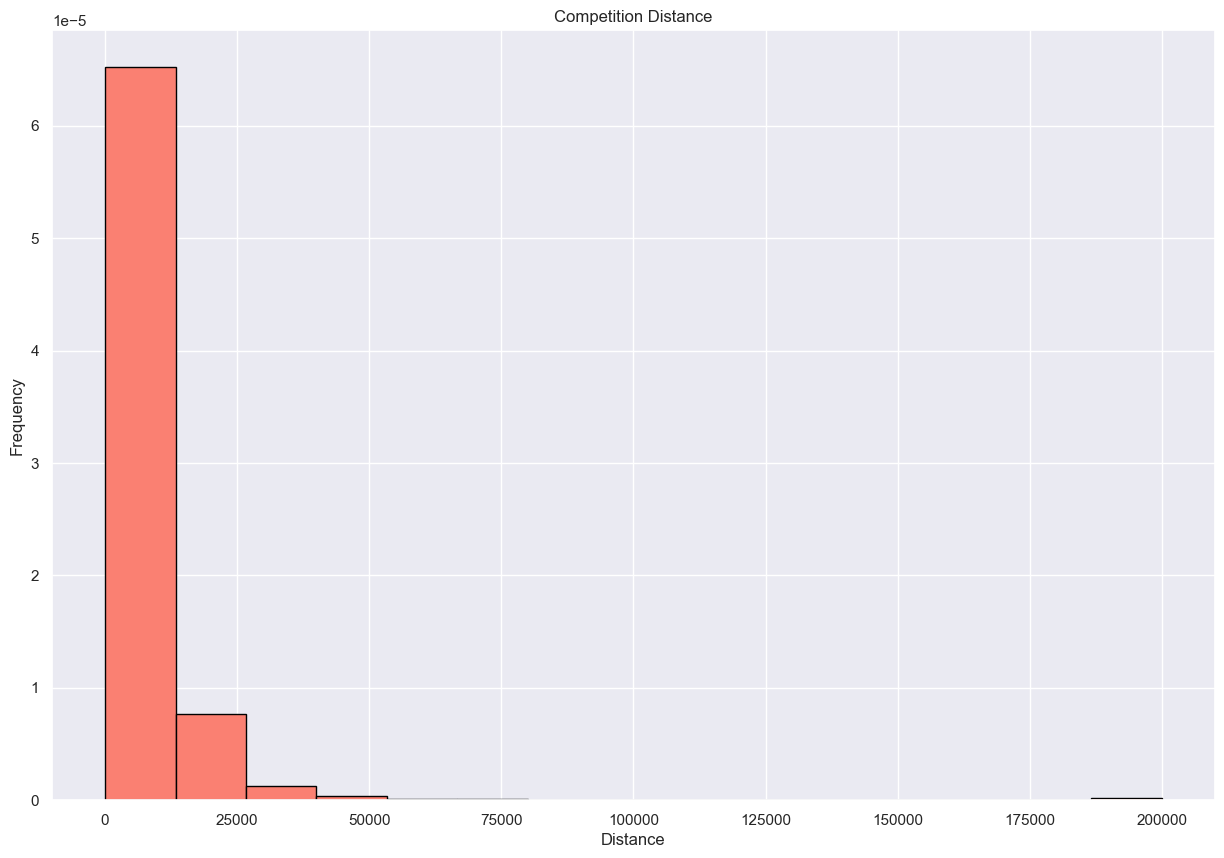

In [22]:
plt.hist(df1['competition_distance'], bins=15, color='salmon', edgecolor='black', density=True)
plt.title("Competition Distance")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

##### 1.7.2 Categorical Attributes

In [23]:
cat_attributes.apply( lambda x: x.nunique())
# or 
#cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

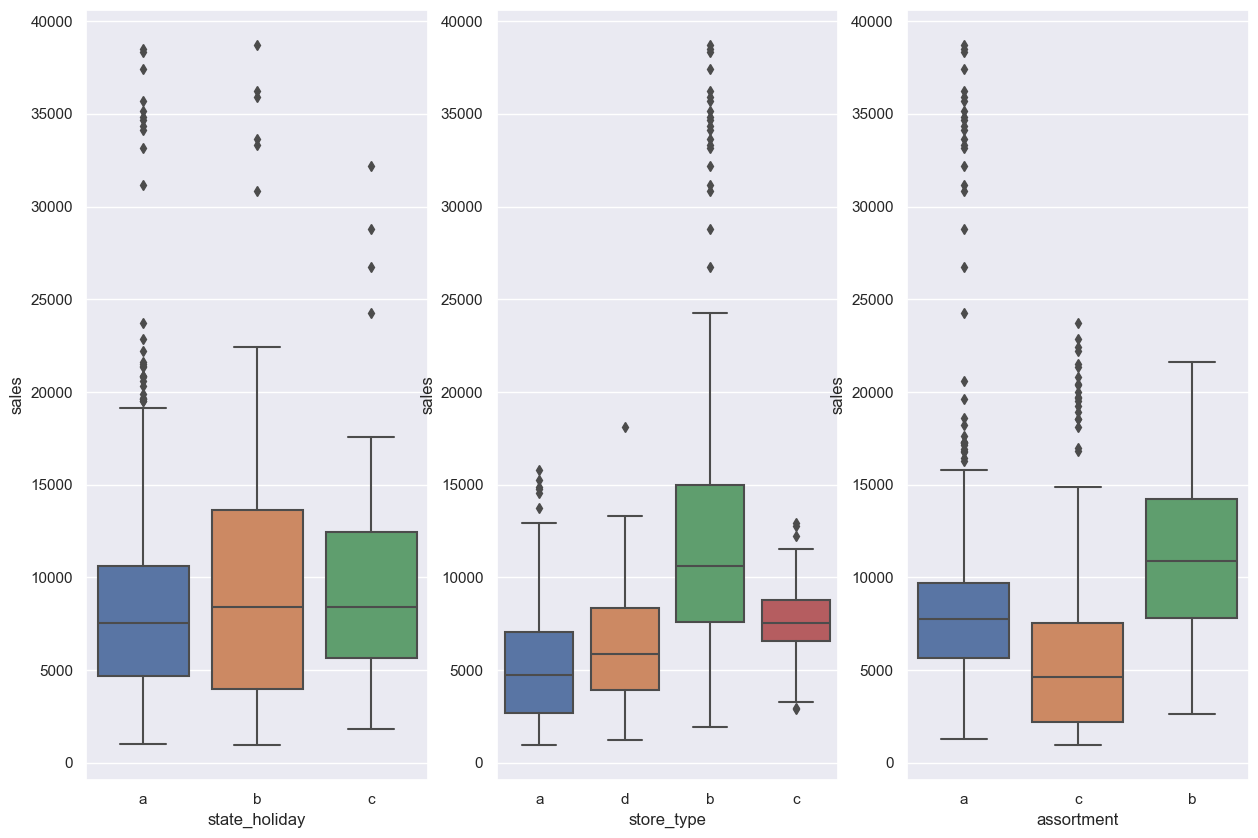

In [139]:
aux1 = df1.loc[ (df1['sales'] > 0) & (df1['state_holiday'] != "0"), : ]
aux2 = df1.loc[ (df1['sales'] > 0) , : ]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1 )

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1 )


plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

#### 1.8. D-Tale

In [25]:
#d = dtale.show(df1)
#d.open_browser()

### 2.0. PASSO 02 - FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

#### 2.1. Mapa Mental de Hipóteses


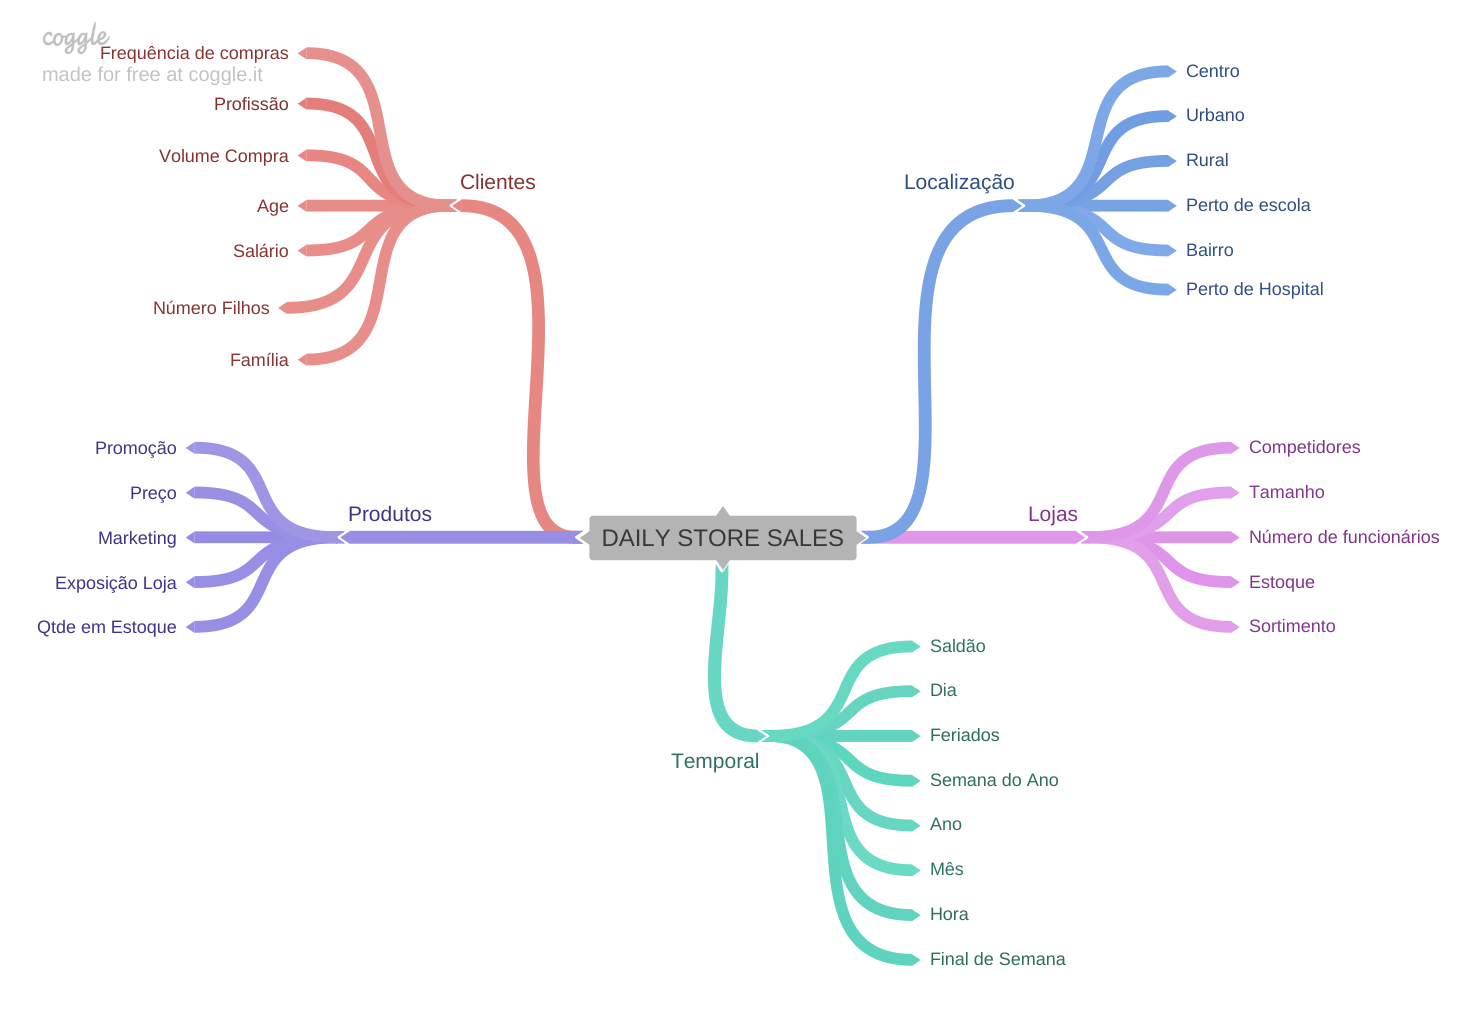

In [27]:
Image('./img/mindmap_hypothesis.png')

#### 2.2. Criacao das Hipoteses


##### 2.2.1. Hiposteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveriam vender mais.

##### 2.2.2. Hiposteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais. 

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais. 

**6.** Lojas com mais dias de promoção deveriam vender mais. 

**7.** Lojas com mais promoções consecutivas deveriam vender mais. 

##### 2.2.3. Hiposteses Tempo

**1.** Lojas abertas durante o feriado do Natal deveriam vender mais. 

**2.** Lojas deveriam vender mais ao longo dos anos. 

**3.** Lojas deveriam vender mais no segundo semestre do ano. 

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês. 

**5.** Lojas deveriam vender menos aos finais de semana. 

**6.** Lojas deveriam vender menos durante os feriados escolares. 

##### 2.2.4 Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais. 

**5.** Lojas com mais dias de promoção deveriam vender mais. 

**6.** Lojas com mais promoções consecutivas deveriam vender mais. 

**7.** Lojas abertas durante o feriado do Natal deveriam vender mais. 

**8.** Lojas deveriam vender mais ao longo dos anos. 

**9.** Lojas deveriam vender mais no segundo semestre do ano. 

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês. 

**11.** Lojas deveriam vender menos aos finais de semana. 

**12.** Lojas deveriam vender menos durante os feriados escolares. 

#### 2.3. Feature Engineering

In [28]:
# derivando as variáveis necessárias

# year
df2['year'] = df2['date'].dt.year
# month 
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since -> time since the competitor opened
df2['competition_since'] = df2['competition_open_since_year'].astype(str) + '-' + df2['competition_open_since_month'].astype(str).str.zfill(2)
df2['competition_since'] = pd.to_datetime(df2['competition_since'], format='%Y-%m')
# df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since -> how long the store is participating in promo2
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str).str.zfill(2)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')) - datetime.timedelta( days = 7)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /7).apply( lambda x: x.days).astype(int)

# assortment
assort_dict = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df2['assortment'] = df2['assortment'].map(assort_dict)

# holidays
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

### 3.0. PASSO 03 - FILTRAGEM DE VARIAVEIS

In [29]:
df3 = df2.copy()

In [30]:
# pickle.dump(df3, open('data/df3.pkl', 'wb'))

In [31]:
#df3 = pickle.load(open('data/df3.pkl', 'rb'))


#### 3.1. Filtragem de Linhas

In [32]:
# considering only opened stores and sales > 0 in the analysis
df3 = df3.loc[ (df3['open'] != 0) & (df3['sales'] > 0), : ]

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

#### 3.2. Selecao de colunas

In [34]:
# reducing dimensionality by dropping columns will not be used in the analysis
cols_drop = ['open', 'customers', 'month_map', 'promo_interval']
df3 = df3.drop(cols_drop, axis = 1)

### 4.0. PASSO 04 - ANALISE EXPLORATORIA DE DADOS (EDA)

In [35]:
df4 = df3.copy()

#### 4.1. Analise Univariada

#### 4.1.1. Response Variable

c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


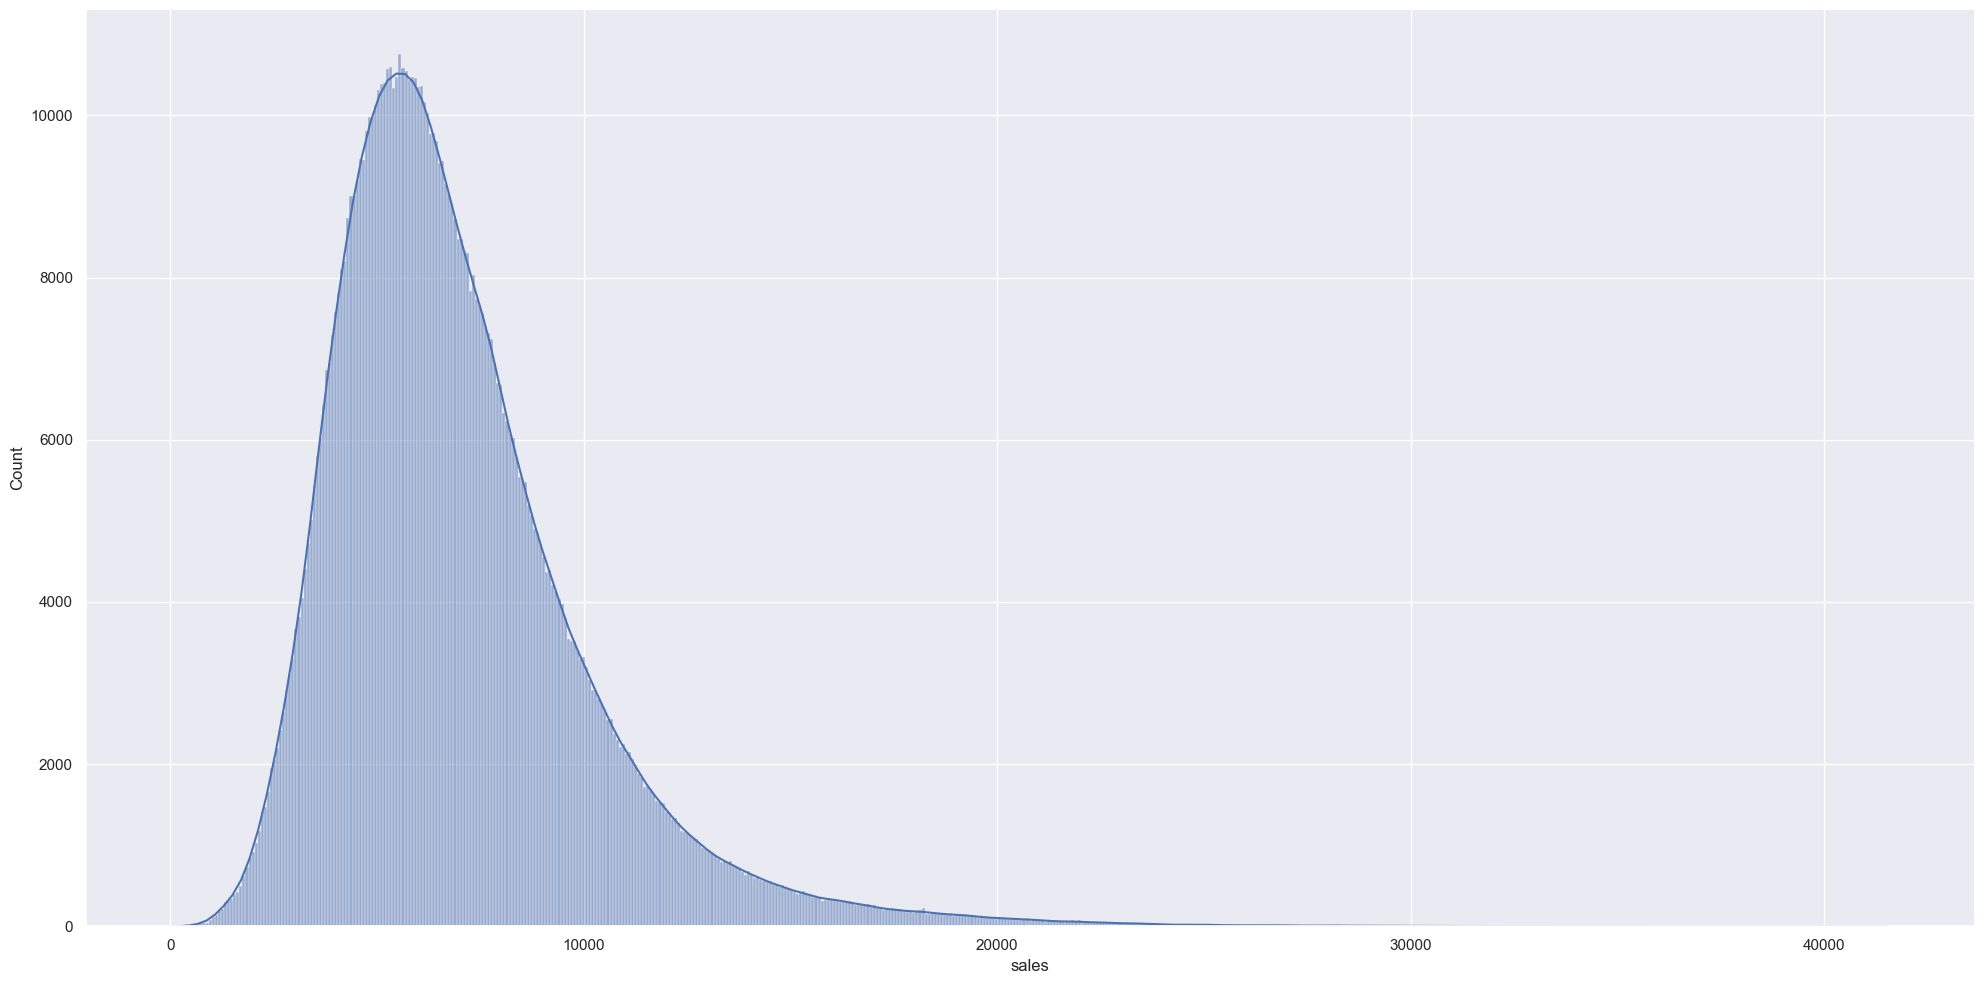

In [36]:
# sales histogram
sns.displot(df4['sales'], kde=True, height=10, aspect=2)

#### 4.1.2. Numerical Variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

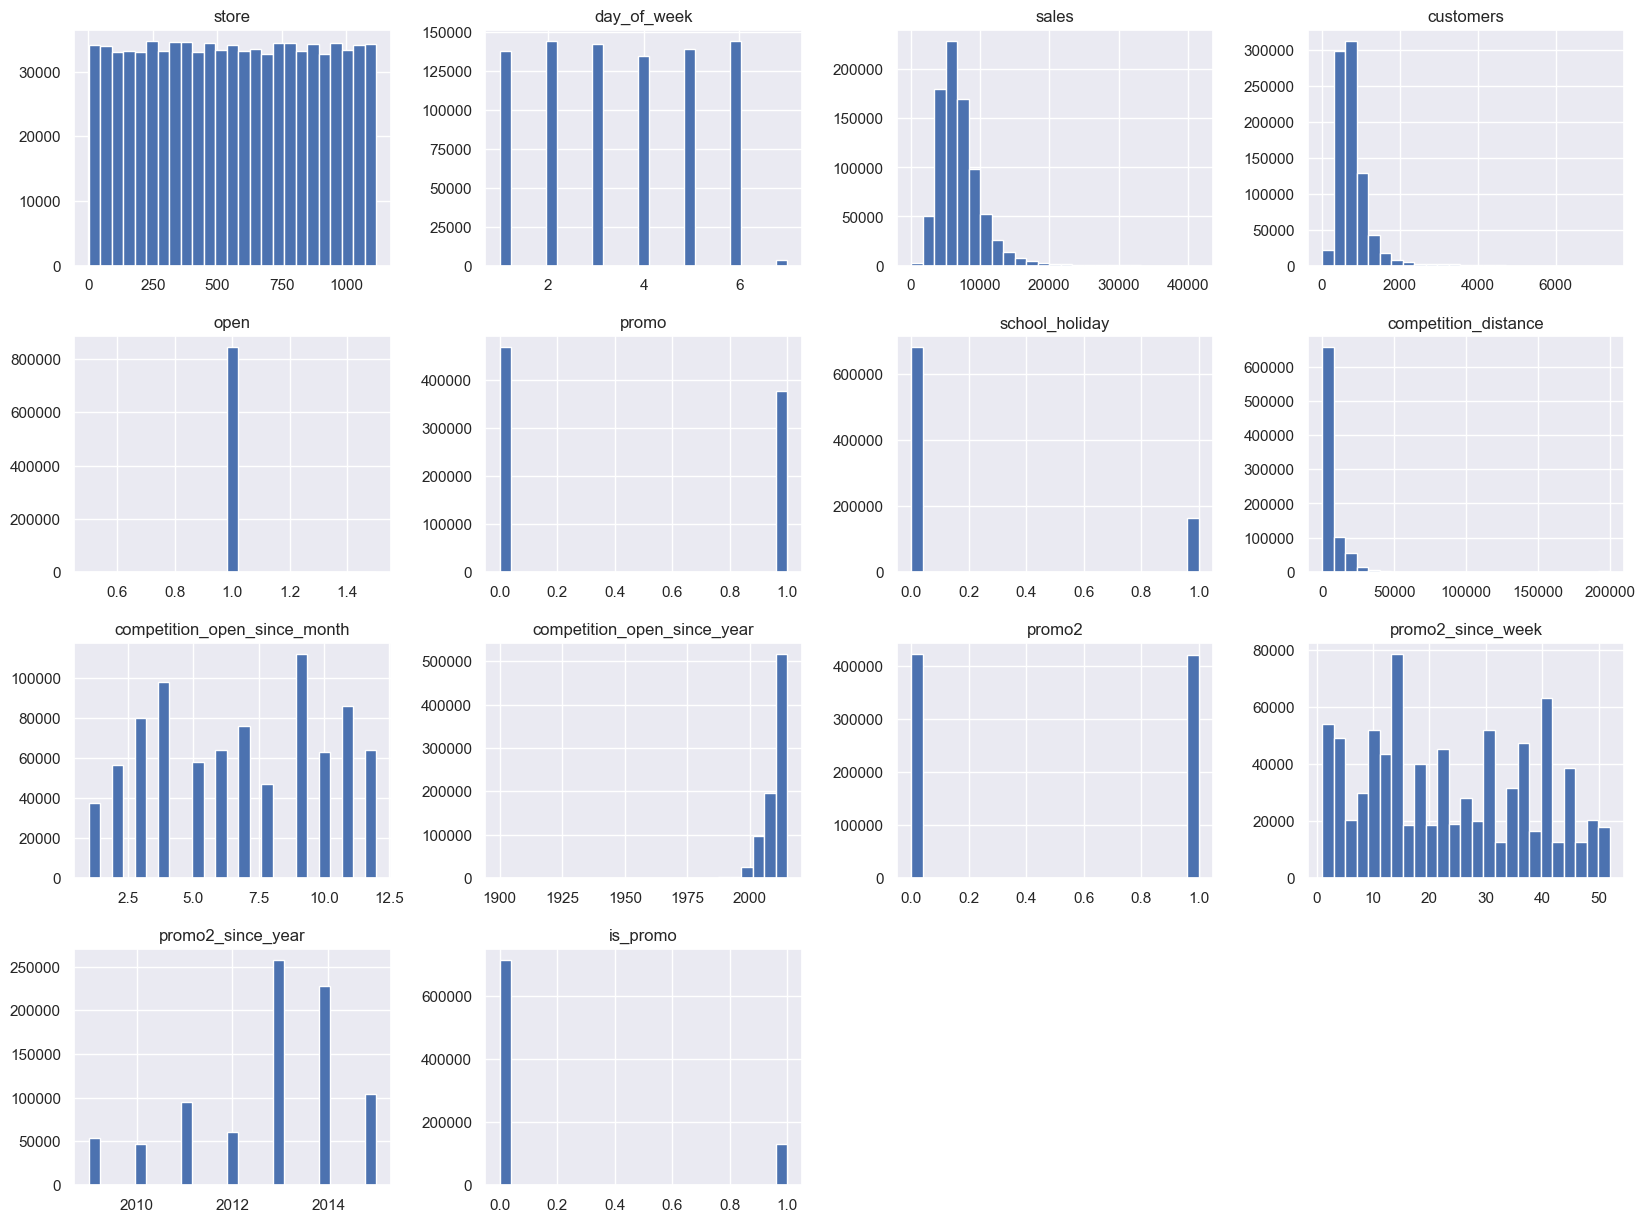

In [37]:
num_attributes.loc[(num_attributes['sales'] > 0) & num_attributes['open'] == 1 ].hist(bins=25, figsize=(20,15))

#### 4.1.3. Categorical Variable

In [38]:
cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

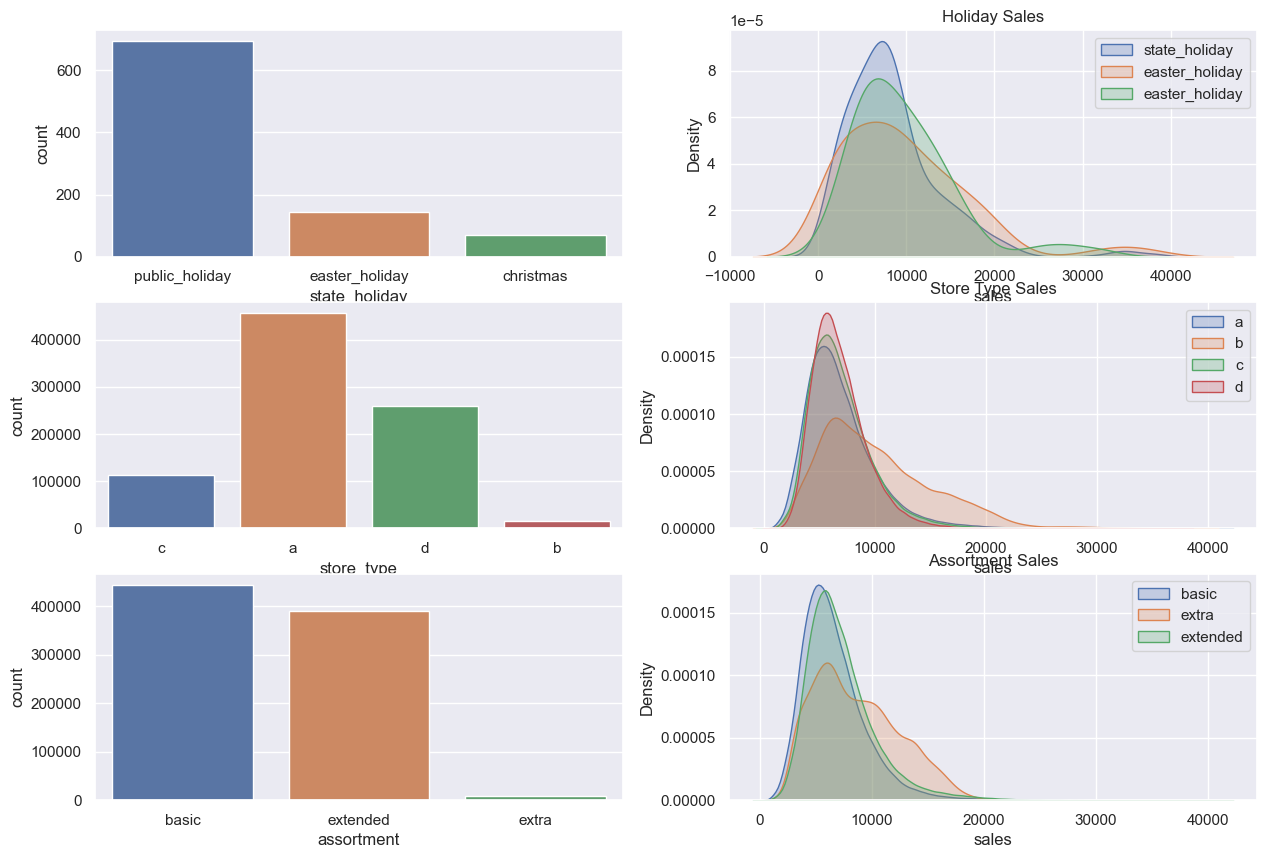

In [39]:
# state holiday
plt.subplot(3,2,1);
a = df4.loc[df4['state_holiday'] != 'regular_day', :];
sns.countplot(x='state_holiday', data=a);

plt.subplot(3,2,2);
sns.kdeplot( df4.loc[df4['state_holiday'] == 'public_holiday', 'sales'], label='state_holiday', fill=True );
sns.kdeplot( df4.loc[df4['state_holiday'] == 'easter_holiday', 'sales'], label='easter_holiday', fill=True );
sns.kdeplot( df4.loc[df4['state_holiday'] == 'christmas', 'sales'], label='easter_holiday', fill=True );
plt.title('Holiday Sales');
plt.legend();

# store_type
plt.subplot(3,2,3);
sns.countplot(x='store_type', data=df4);

plt.subplot(3,2,4);
sns.kdeplot( df4.loc[df4['store_type'] == 'a', 'sales'], label='a', fill=True );
sns.kdeplot( df4.loc[df4['store_type'] == 'b', 'sales'], label='b', fill=True );
sns.kdeplot( df4.loc[df4['store_type'] == 'c', 'sales'], label='c', fill=True );
sns.kdeplot( df4.loc[df4['store_type'] == 'd', 'sales'], label='d', fill=True );
plt.title('Store Type Sales');
plt.legend();

# assortment
plt.subplot(3,2,5);
sns.countplot(x='assortment', data=df4);

plt.subplot(3,2,6);
sns.kdeplot( df4.loc[df4['assortment'] == 'basic', 'sales'], label='basic', fill=True );
sns.kdeplot( df4.loc[ df4['assortment'] == 'extra', 'sales'], label='extra', fill=True );
sns.kdeplot( df4.loc[ df4['assortment'] == 'extended', 'sales'], label='extended', fill=True)
plt.title('Assortment Sales');
plt.legend();

#### 4.2. Analise Bivariada

##### **H1.** Lojas com maior sortimento deveriam vender mais

**VERDADEIRA** Lojas com maior sortimento vendem mais, porém apenas 0.8% das lojas têm sortimento extra

In [40]:
aux1 = df4.loc[ :, ['assortment', 'store']].groupby('assortment').nunique().reset_index()

aux1['% assortment'] = round(100 * aux1['store'] / aux1['store'].sum(),1)

aux1

,assortment,store,% assortment
0,basic,593,53.2
1,extended,513,46.0
2,extra,9,0.8


In [41]:
df4['assortment'].value_counts().to_frame().reset_index()

,assortment,count
0,basic,444875
1,extended,391254
2,extra,8209


<Axes: xlabel='year_week'>

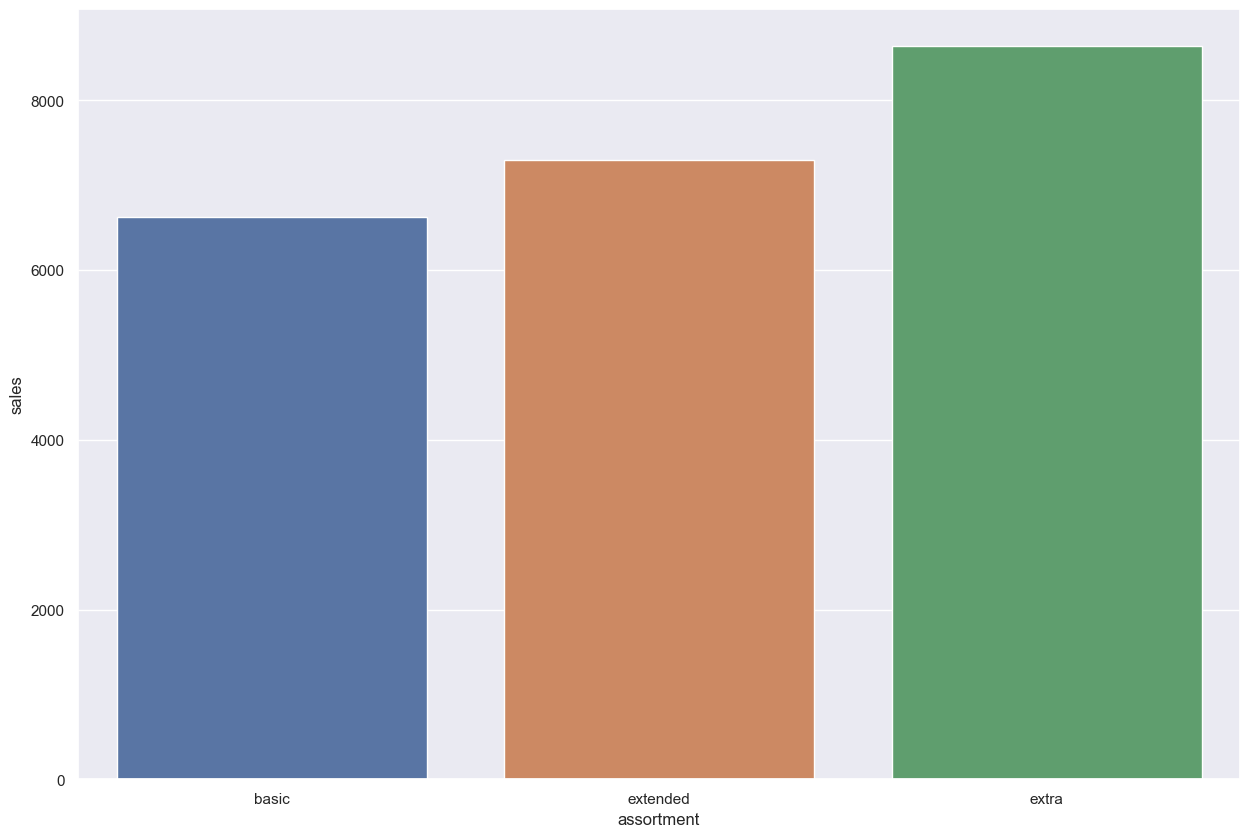

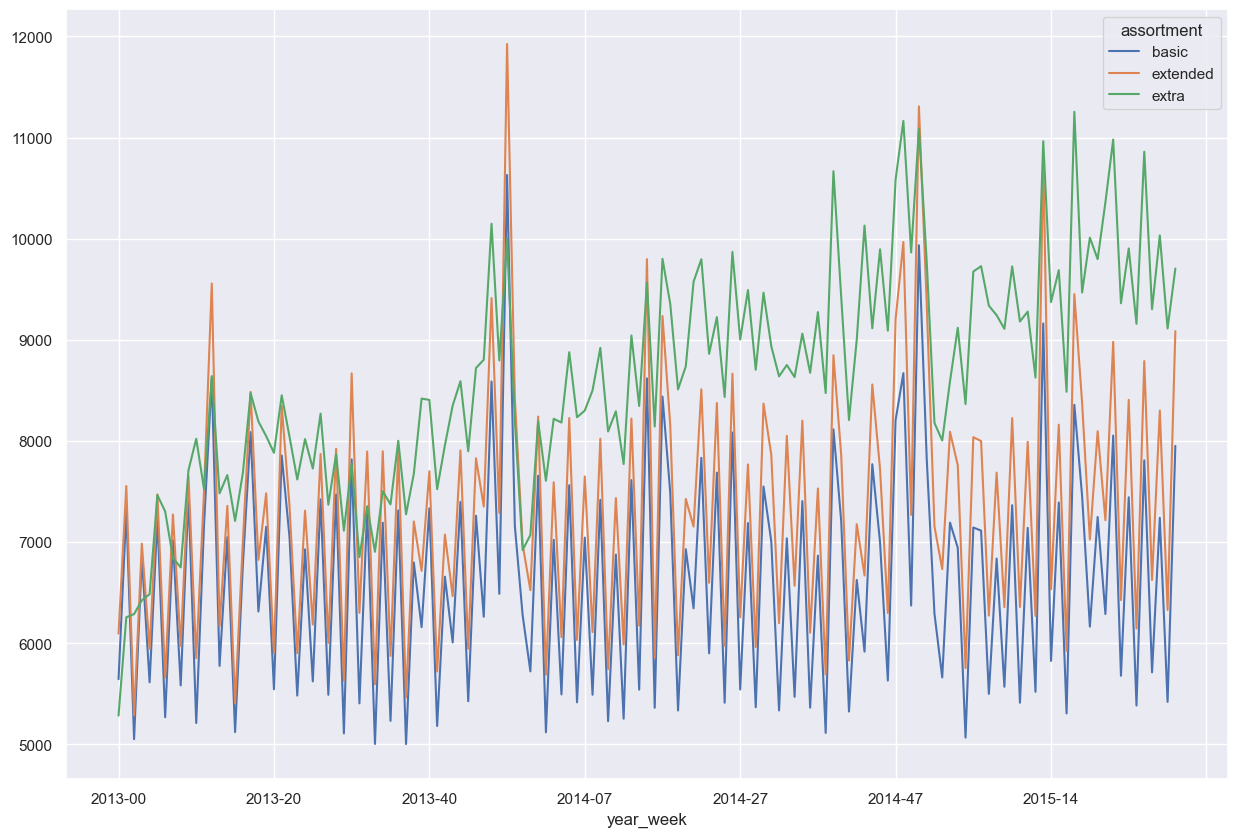

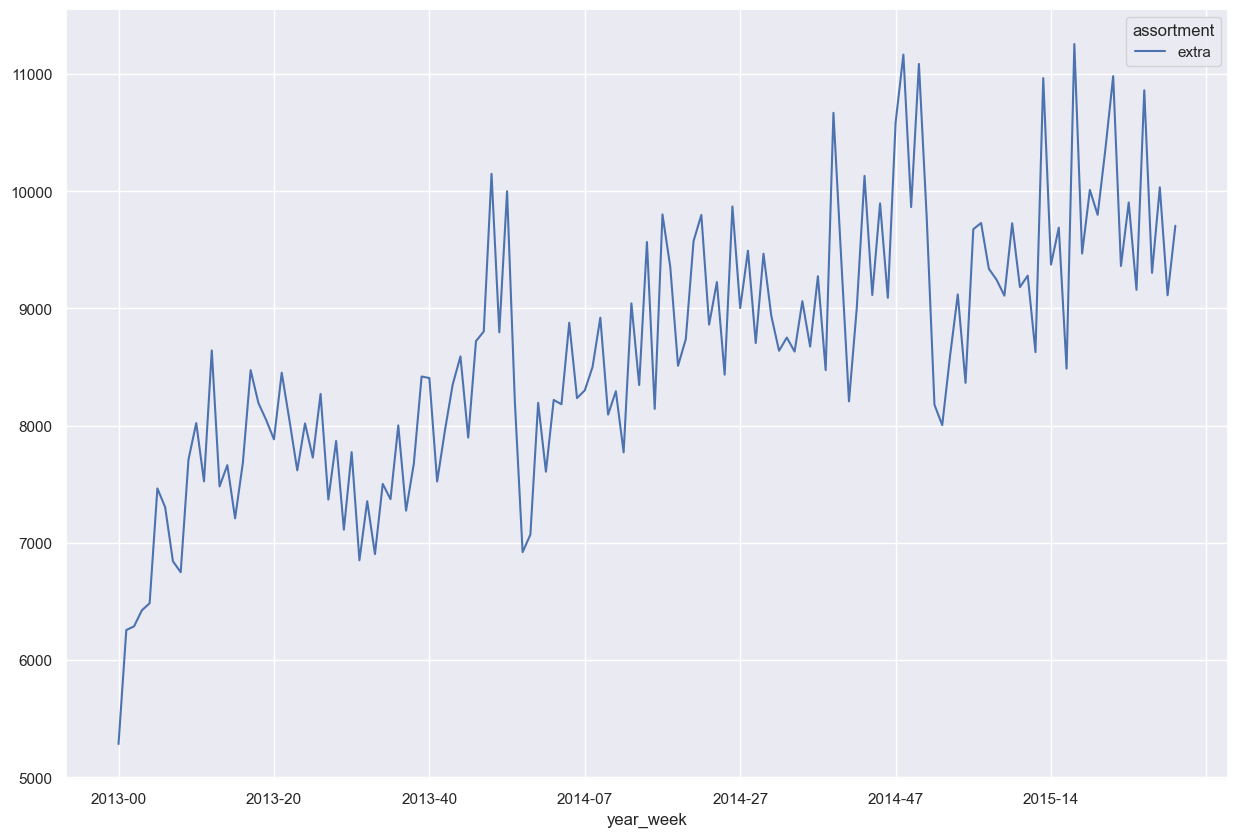

In [42]:
# check which assortment sells more
aux1 = df4.loc[ :, ['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# weekly average sales per assortment type 
aux2 = df4.loc[ :, ['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

#analisando o comportamento semanal do sortimento "extra"
aux3 = aux2.loc[ aux2['assortment'] == 'extra', :]
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()

##### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com competidores mais próximos vendem mais.  

C:\Users\Felipe\AppData\Local\Temp\ipykernel_18720\3395631009.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1.loc[ : , ['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index();
c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


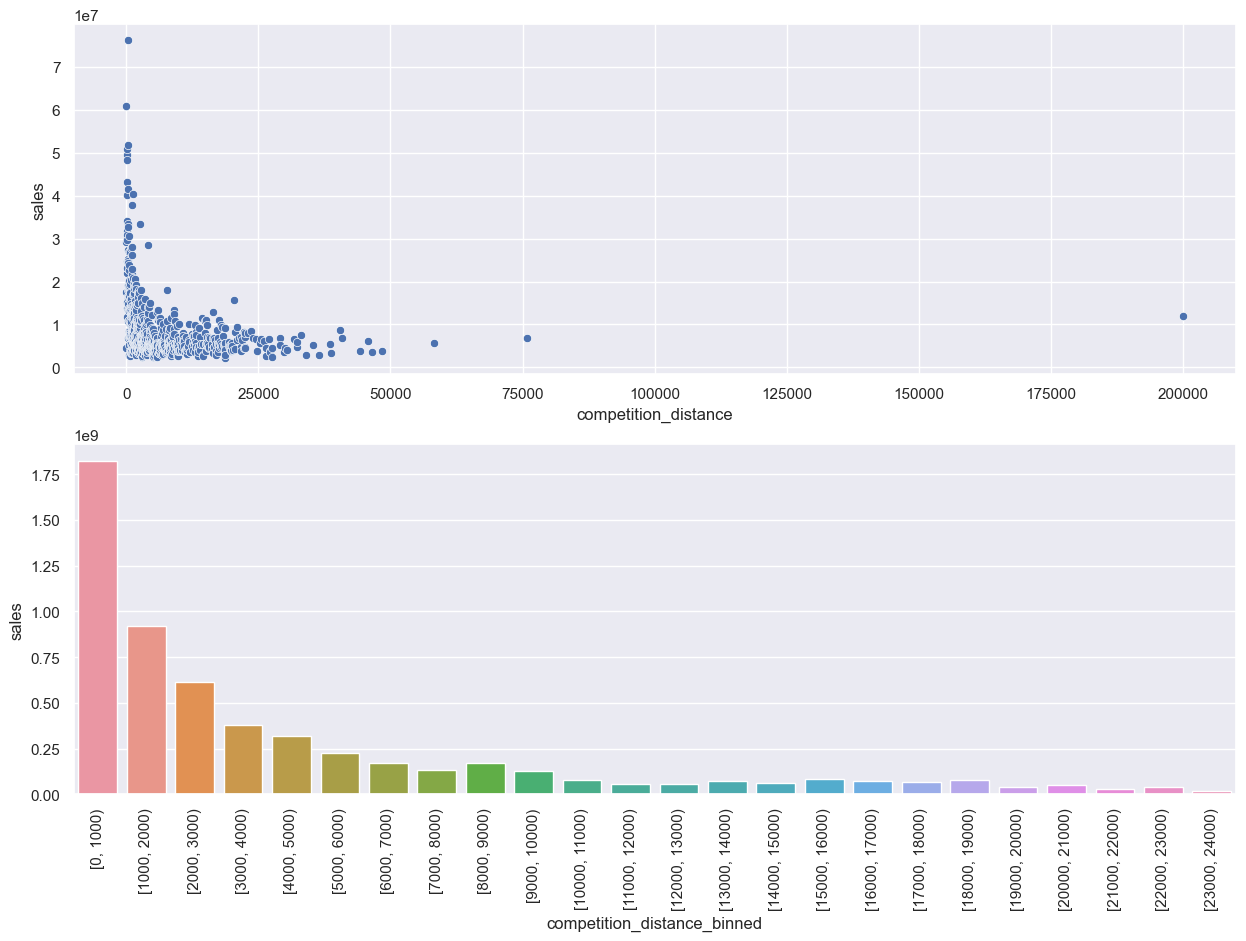

In [43]:
# filtering dataset and selection columns
aux1 = df4.loc[ : , ['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(2,1,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(2,1,2)
# define bins with np.arange
bins = list(np.arange(0, 25000,1000))

# create new competition_distance_binned column
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins, right=False);
aux2 = aux1.loc[ : , ['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index();

# create barplot
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

In [44]:
# another way of doing it
# # filtering dataset and selection columns
# aux1 = df4.loc[ df4['competition_distance'] < 25000, ['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# # define bins with pandas cut
# bins = pd.cut(aux1['competition_distance'], bins=25)

# # grouping by bins and summing sales
# grouped = aux1.groupby(bins)['sales'].sum().reset_index()

# # create barplot
# sns.barplot(x='competition_distance', y='sales', data=grouped)

##### **H3.** Lojas com competidores há mais tempo deveriam vender mais. 

**FALSA**  Lojas com competidores há mais tempo vendem menos.

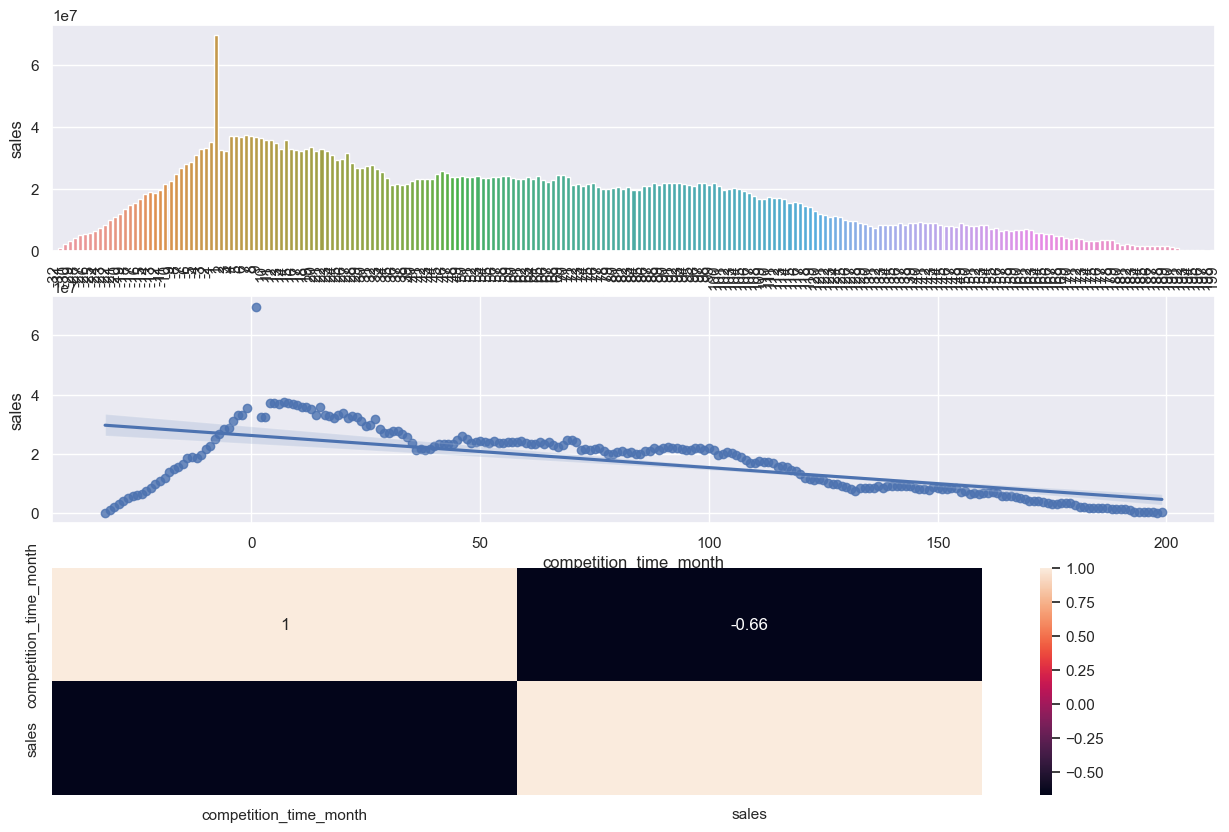

In [45]:
aux1 = df4.loc[ (df4['competition_time_month'] < 200) & (df4['competition_time_month'] != 0), ['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

plt.subplot(3,1,1)
sns.barplot(x='competition_time_month', y='sales', data=aux1);
plt.xticks(rotation=90);

plt.subplot(3,1,2);
sns.regplot(x='competition_time_month', y='sales', data=aux1);

plt.subplot(3,1,3);
sns.heatmap( aux1.corr( method='pearson'), annot=True);



##### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais. 

**FALSA** Lojas com promoções ativas por mais tempo vendem menos.

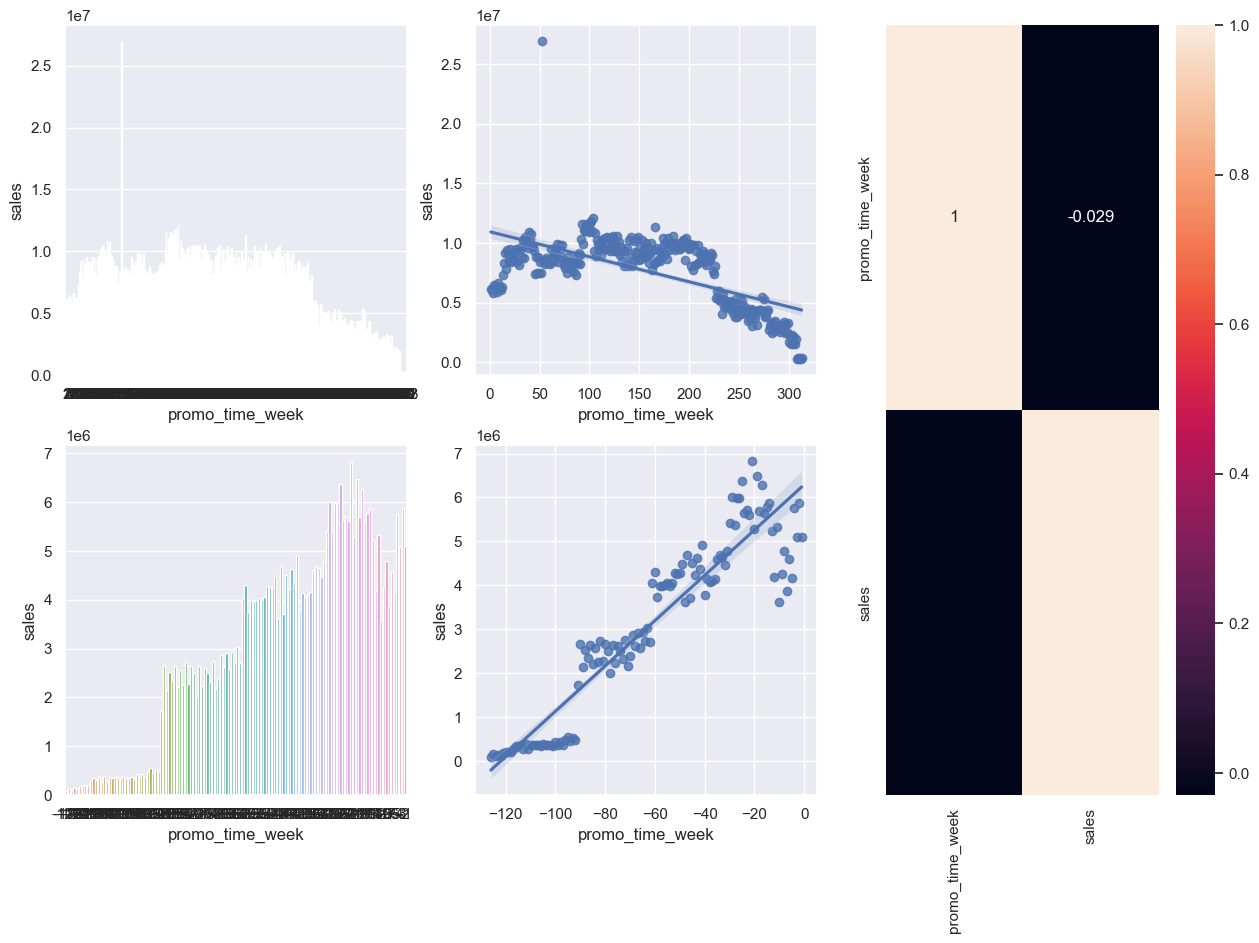

In [46]:
aux1 = df4.loc[ : , ['promo_time_week', 'sales'] ].groupby('promo_time_week').sum().reset_index()
# took part in promo2
aux2 = aux1.loc[ aux1['promo_time_week'] > 0, : ]
# not took part in promo2
aux3 = aux1.loc[ aux1['promo_time_week'] < 0, : ]

grid = GridSpec(2,3)

# with promo2 active (extended promotion)
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

# without promo2 active
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

# correlation heatmap between promo_time_week and sales
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.xticks(rotation=90);

##### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

Segundo round do CRISP

##### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com promoções ativas por mais tempo acabam vendendo menos

In [47]:
# checking amount of promo and promo2
df4.loc[:, ['promo', 'promo2', 'year']].groupby('year').sum().sort_values(by='year').reset_index()

,year,promo,promo2
0,2013,146988,172581
1,2014,138408,148512
2,2015,91479,99953


In [48]:
# ccomparing average sales with promo and promo2
df4.loc[:, ['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values(by='sales', ascending=True).reset_index()

,promo,promo2,sales
0,0,1,1289362241
1,1,1,1472275754
2,0,0,1482612096
3,1,0,1628930532


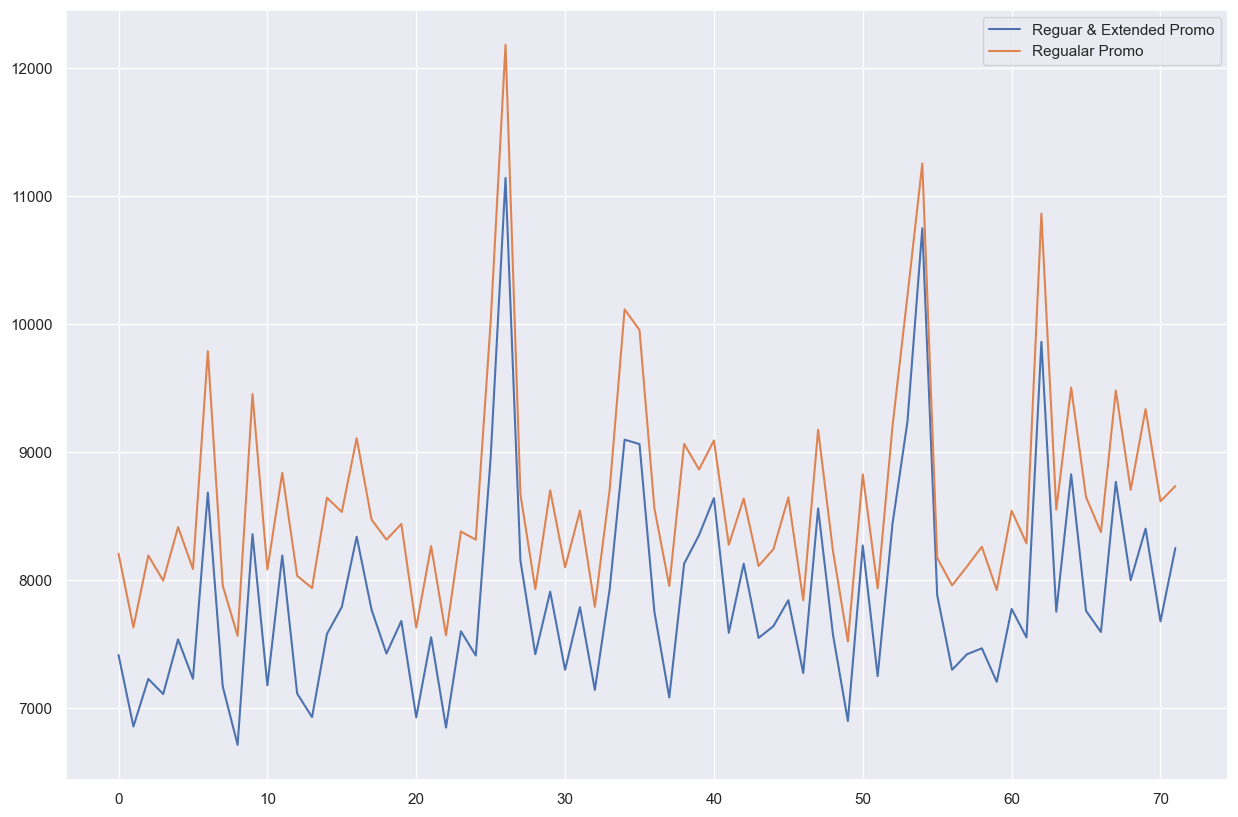

In [140]:
# sales evolution with promo and promo2 active
aux1 = df4.loc[ (df4['promo'] == 1) & (df4['promo2'] == 1), ['year_week', 'sales']].groupby('year_week').mean().reset_index();
ax = aux1.plot();

# sales evolution with just promo active (no promo2)
aux2 = df4.loc[ (df4['promo'] == 1) & (df4['promo2'] == 0), ['year_week', 'sales']].groupby('year_week').mean().reset_index();
aux2.plot(ax=ax)

ax.legend(labels= ['Reguar & Extended Promo', 'Regualar Promo'])

##### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** Na média total de vendas com todos os anos, o feriado de Natal vende um pouco menos que o feriado de Páscoa, o feriado com mais vendas. 

In [50]:
a = df4.loc[ df4['state_holiday'] == 'easter_holiday', ['year', 'date']].drop_duplicates().sort_values(by='date').reset_index(drop=True)
b = df4.loc[ df4['state_holiday'] == 'christmas', ['year', 'date']].drop_duplicates().sort_values(by='date').reset_index(drop=True)
print(a)
print(b)

   year       date
0  2013 2013-03-29
1  2013 2013-04-01
2  2014 2014-04-18
3  2014 2014-04-21
4  2015 2015-04-03
5  2015 2015-04-06
   year       date
0  2013 2013-12-25
1  2013 2013-12-26
2  2014 2014-12-25
3  2014 2014-12-26


<Axes: xlabel='year', ylabel='sales'>

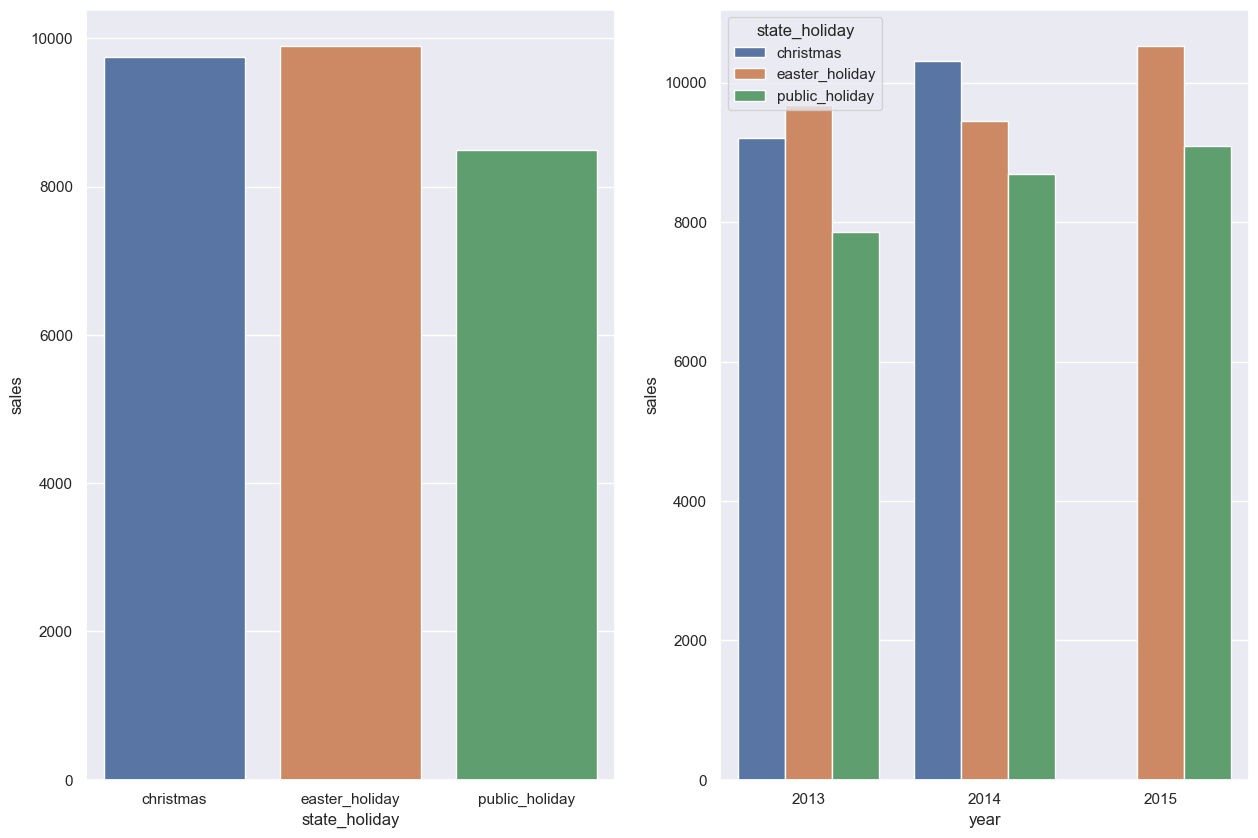

In [51]:
aux =  df4.loc[ df4['state_holiday'] != 'regular_day', :]
aux1 = aux.loc[ :, ['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
aux2 = aux.loc[ :, ['state_holiday', 'sales', 'year']].groupby(['year', 'state_holiday']).mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

##### **H8.** Lojas deveriam vender mais ao longo dos anos.

**FALSA**  As lojas estão vendendo menos ao longo dos anos. Porém 2015 parece que está recuperando.

In [52]:
df4.loc[ :, ['sales', 'year']].groupby('year').mean().reset_index()

,year,sales
0,2013,6814.775168
1,2014,7026.128505
2,2015,7088.235123


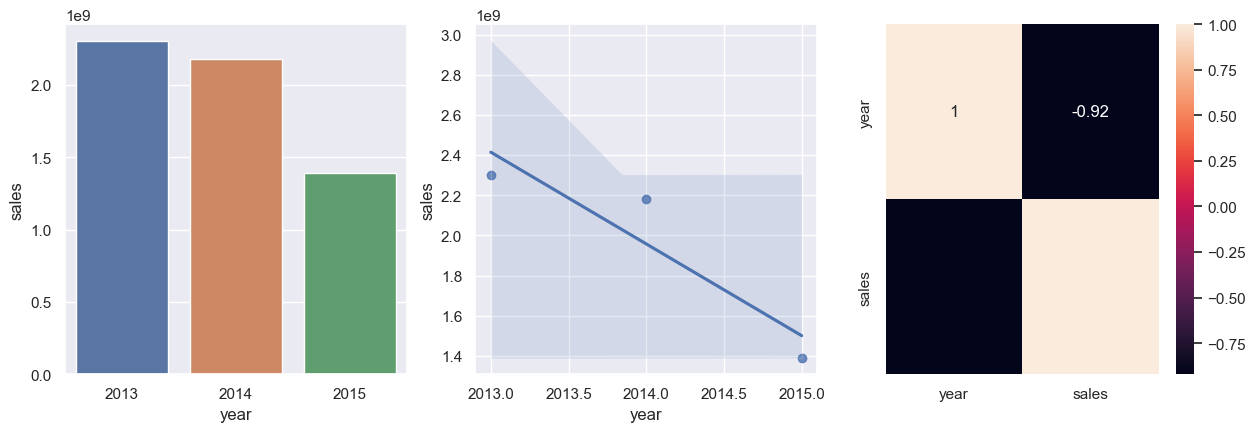

In [53]:
aux1 = df4.loc[ :, ['sales', 'year']].groupby('year').sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(2,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(2,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [54]:
df4['year_month_sales'] = df4['year'].astype(str) + '-' + df4['month'].astype(str).str.zfill(2)
df4['year_month_sales'] = pd.to_datetime(df4['year_month_sales'], format='%Y-%m')

c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


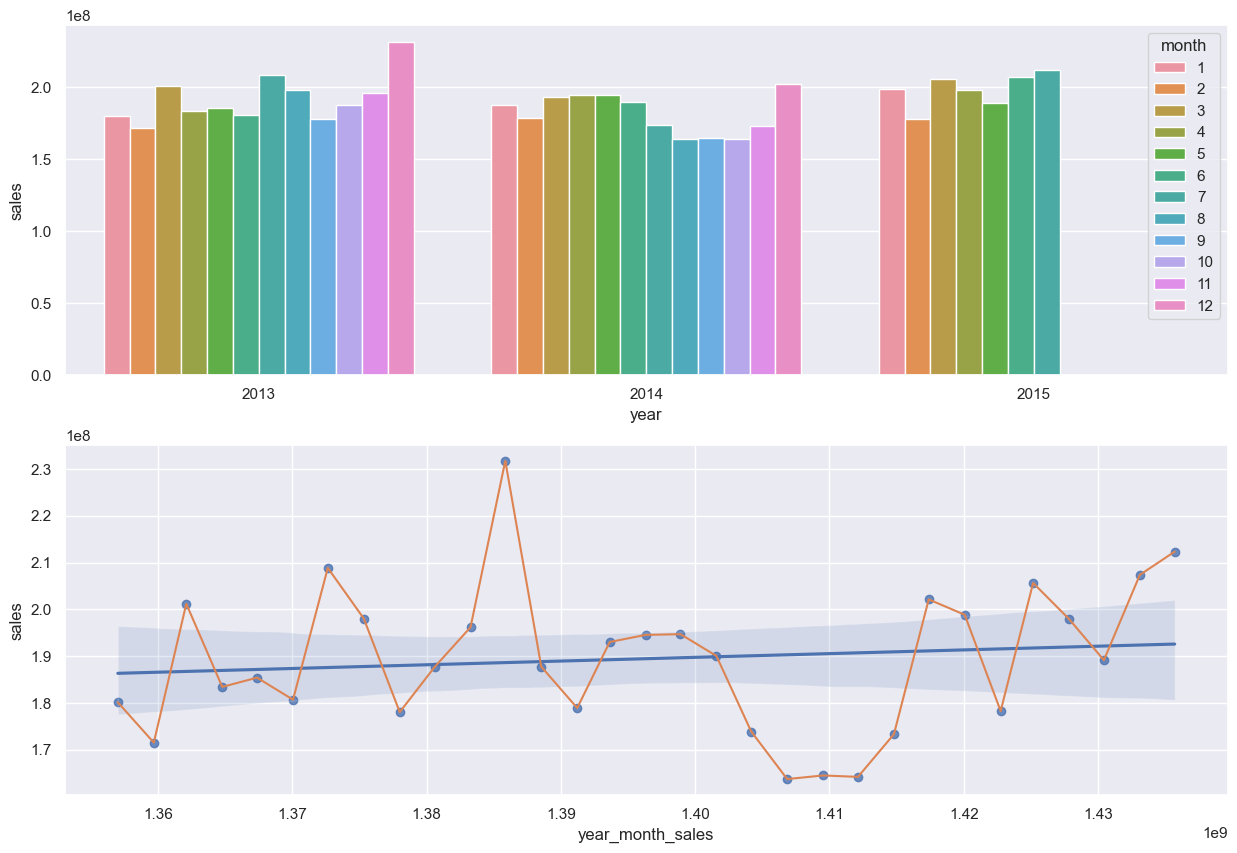

In [142]:
aux = df4.loc[ :, ['sales', 'year', 'month']].groupby(['year', 'month']).sum().reset_index()

aux1 = df4.loc[  : , ['year_month_sales', 'sales']].groupby('year_month_sales').sum().reset_index();
aux1['year_month_sales'] = aux1['year_month_sales'].apply(lambda x: x.timestamp())

plt.subplot(2,1,1)
aux['month'] = aux['month'].astype(str)
sns.barplot(x='year', y='sales', hue='month', data=aux);

plt.subplot(2,1,2)
sns.regplot(x='year_month_sales', y='sales', data=aux1);

plt.subplot(2,1,2)
sns.lineplot(x='year_month_sales', y='sales', data=aux1);


##### **H9.** Lojas deveriam vender mais no segundo semestre do ano. 

**VERDADEIRA** Lojas vendem mais no segundo semestre do ano.

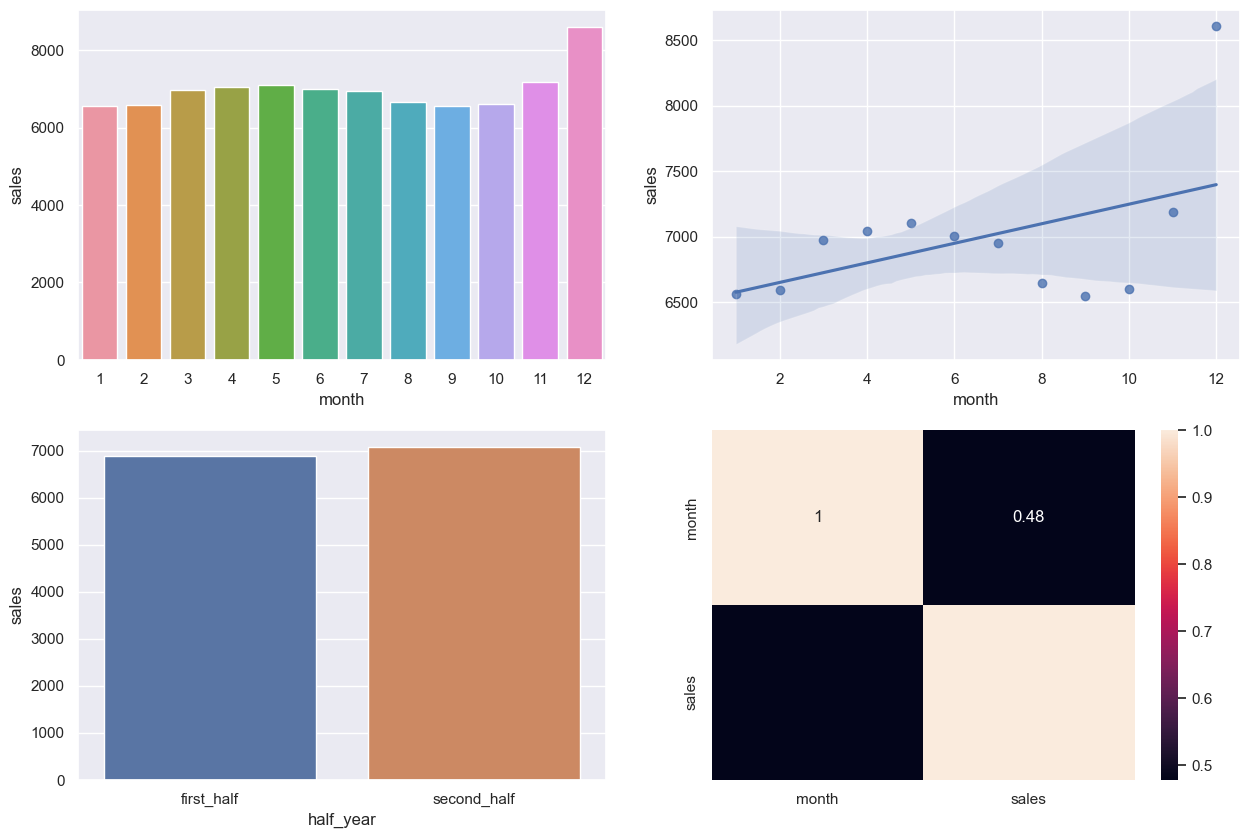

In [56]:
# average sales per month
aux1 = df4.loc[ :, ['month', 'sales']].groupby('month').mean().reset_index();

# barplot with average sales per month
plt.subplot(2,2,1)
sns.barplot(x='month', y='sales', data=aux1);

# regplot with average sales per month
plt.subplot(2,2,2)
sns.regplot(x='month', y='sales', data=aux1);

# average sales by half of the year
# half_year_dict = { 1: 'first_half', 2: 'first_half', 3: 'first_half', 4: 'first_half', 5: 'first_half', 6: 'first_half',  7: 'second_half',  
#                    8: 'second_half',  9: 'second_half',  10: 'second_half',  11: 'second_half',  12: 'second_half'}
# aux1['half_year'] = aux1['month'].map(half_year_dict)
aux1['half_year'] = aux1['month'].apply( lambda x: 'first_half' if x <=6 else 'second_half')


aux2 = aux1.loc[ :, ['half_year', 'sales']].groupby('half_year').mean().reset_index()
plt.subplot(2,2,3)
sns.barplot(x='half_year', y='sales', data=aux2);

plt.subplot(2,2,4)
aux3 = df4.loc[ :, ['month', 'sales']].groupby('month').mean().reset_index();
sns.heatmap(aux3.corr(method='pearson'), annot=True);



##### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês. 
**FALSA** A venda média diária é maior nos 10 primeiros dias do mês.

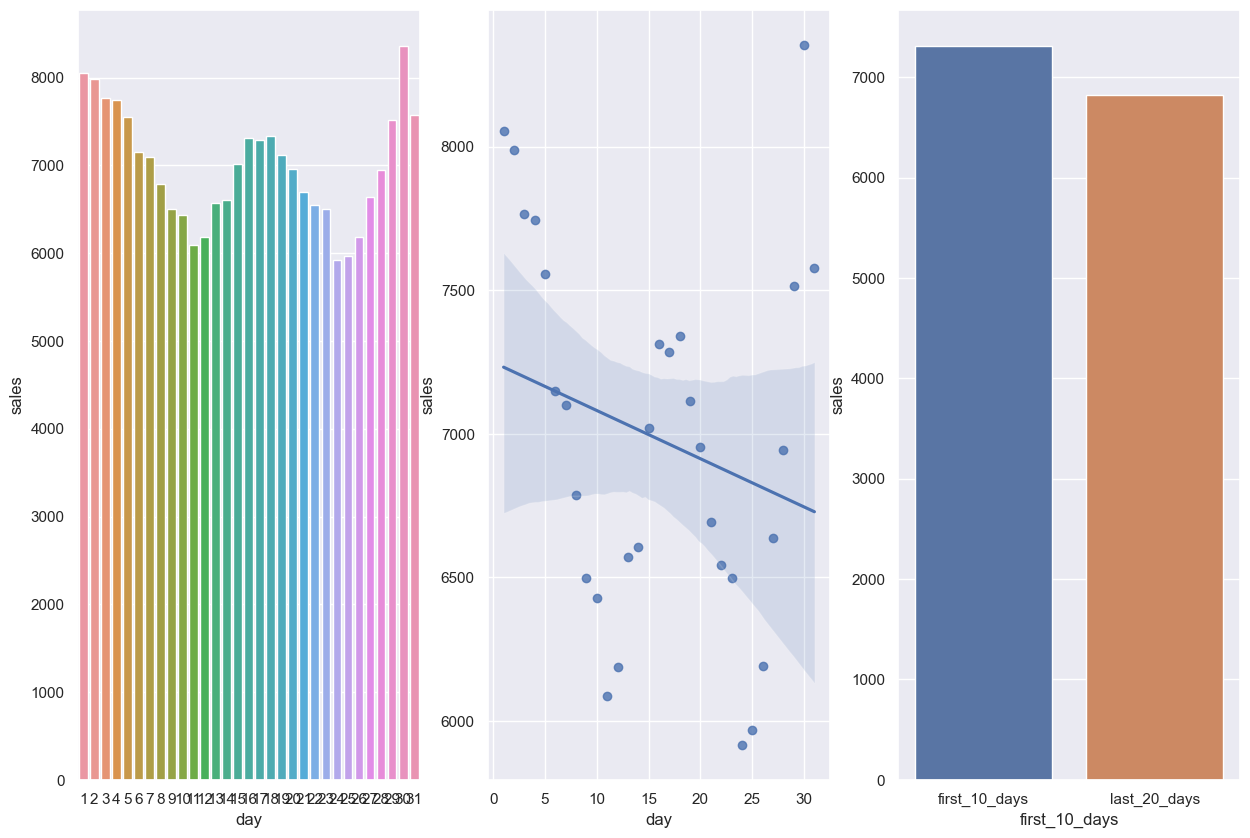

In [144]:
aux1 = df4.loc[ :, ['sales', 'day']].groupby('day').mean().reset_index();

plt.subplot(1,3,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day', y='sales', data=aux1);

aux1['first_10_days'] = aux1['day'].apply( lambda x: 'first_10_days' if x <=10 else 'last_20_days')
aux2 = aux1.loc[ :, ['first_10_days', 'sales']].groupby('first_10_days').mean().reset_index();
plt.subplot(1,3,3)
sns.barplot(x='first_10_days', y='sales', data=aux2);


##### **H11.** Lojas deveriam vender menos aos finais de semana. 
**VERDADEIRA** As lojas vendem mais nos dias úteis da semana. Porém, domingo é o segundo melhor dia de vendas na média.

In [58]:
df4['day_of_week'].value_counts().sort_values().to_frame().reset_index()

,day_of_week,count
0,7,3593
1,4,134626
2,1,137557
3,5,138633
4,3,141922
5,2,143955
6,6,144052


   day_of_week        sales
0            1  8216.252259
1            2  7088.409086
2            3  6728.786679
3            4  6768.214973
4            5  7073.034133
5            6  5875.084935
6            7  8224.723908


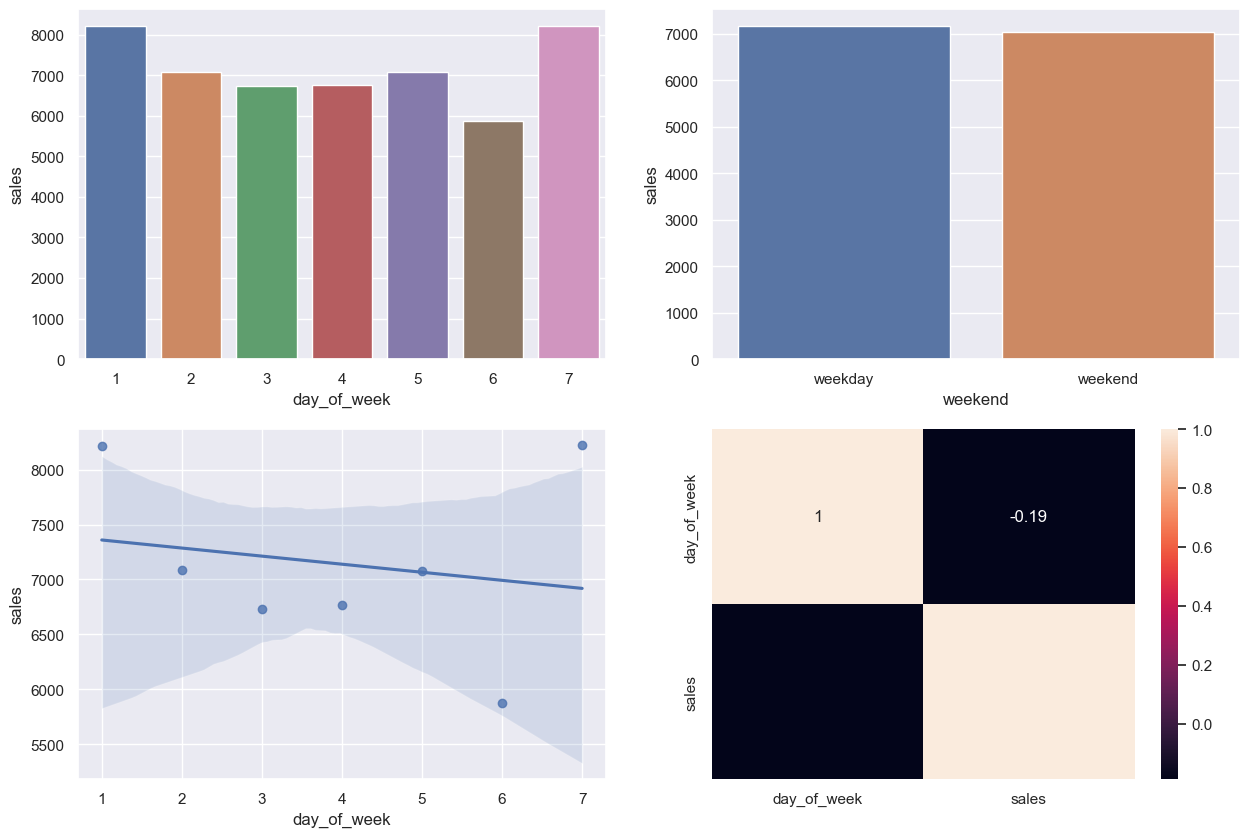

In [59]:
aux1 = df4.loc[ :, ['sales', 'day_of_week']].groupby('day_of_week').mean().reset_index();
print(aux1)
plt.subplot(2,2,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

aux2 = df4.loc[ :, ['sales', 'day_of_week']].groupby('day_of_week').mean().reset_index();
aux2['weekend'] = aux2['day_of_week'].apply( lambda x: 'weekend' if x == 6 or x == 7 else 'weekday')
aux2 = aux2.loc[ :, ['sales', 'weekend']].groupby('weekend').mean().reset_index();
plt.subplot(2,2,2)
sns.barplot(x='weekend', y='sales', data=aux2);

plt.subplot(2,2,3)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### **H12.** Lojas deveriam vender menos durante os feriados escolares. 
**VERDADEIRA**  As vendas durante os feriados escoleares é menor, porém a média diária de vendas é maior quando há feriados escolares.

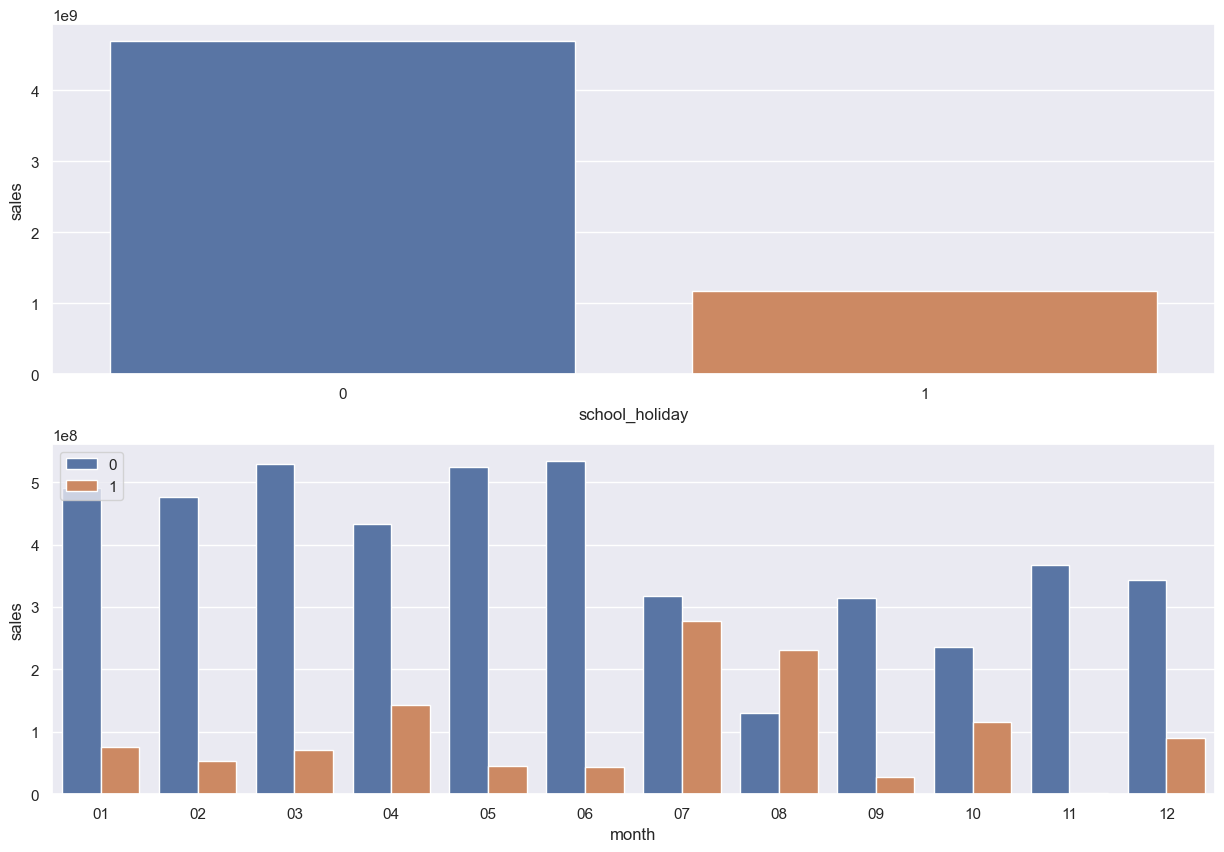

In [147]:
aux1 = df4.loc[ :, ['sales', 'school_holiday']].groupby('school_holiday').sum().reset_index();
aux1['school_holiday'] = aux1['school_holiday'].astype(str)

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4.loc[ :, ['sales', 'month', 'school_holiday']].groupby(['month', 'school_holiday']).sum().reset_index();
aux2['school_holiday'] = aux2['school_holiday'].astype(str)
aux2['month'] = aux2['month'].astype(str).str.zfill(2)
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales',hue='school_holiday' , data=aux2);
plt.legend(loc='upper left');

#### 4.2.1. Resumo das Hipóteses

In [61]:
tab = [ ['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Verdadeira', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Verdadeira', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Falsa        Baixa


#### 4.3. Analise Multivariada

#### 4.3.1. Numerical Attributes

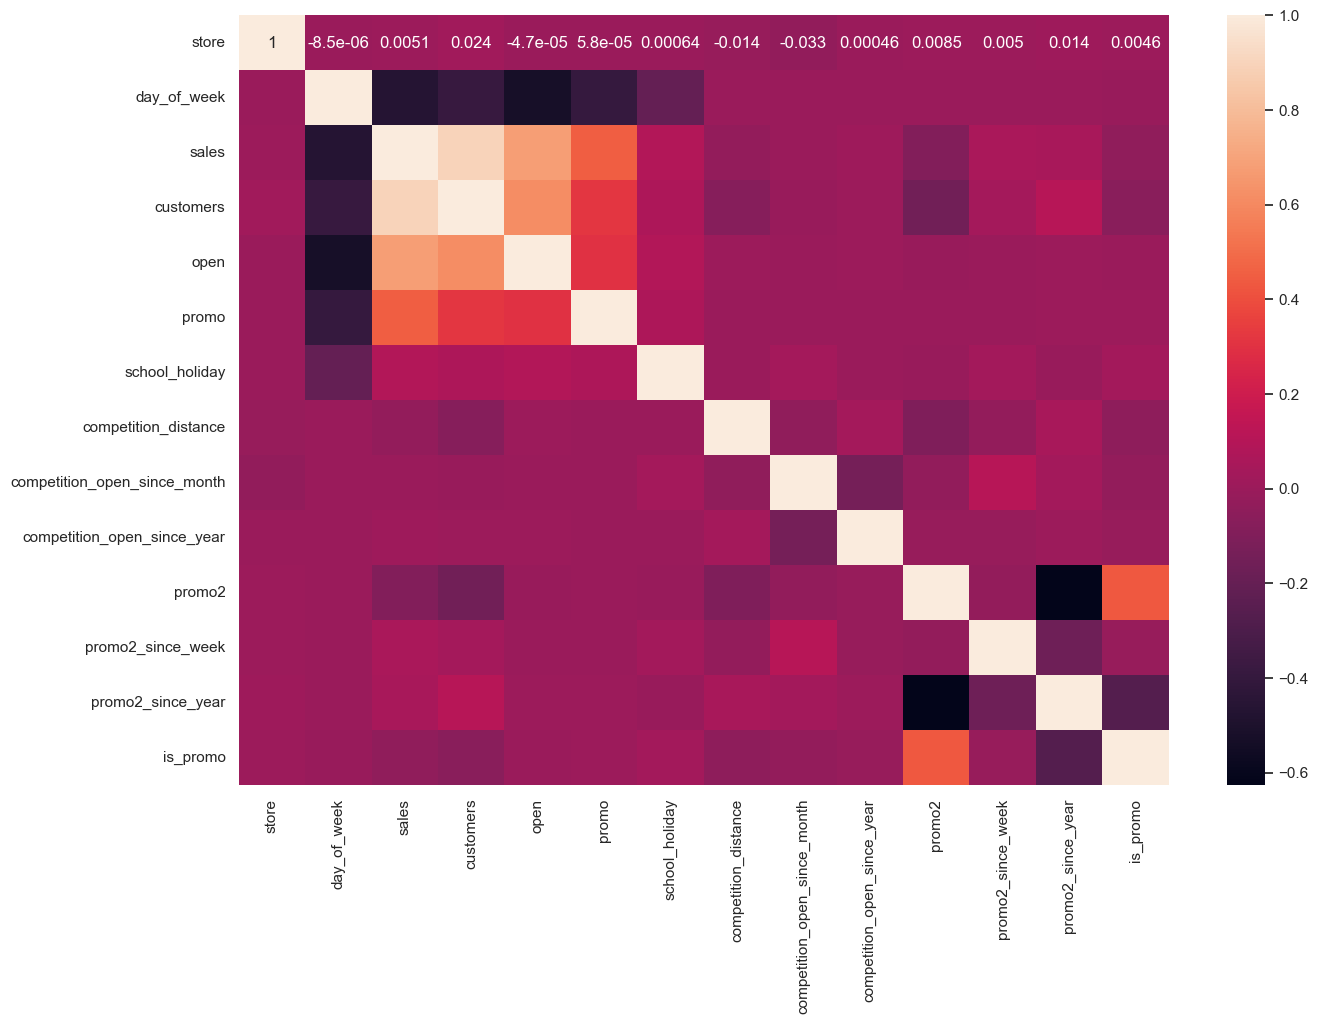

In [149]:
correlation = num_attributes.corr(method='pearson')

sns.heatmap(correlation, annot=True);

In [63]:
print(pd.DataFrame(correlation))

                                 store  day_of_week     sales  customers      open     promo  school_holiday  competition_distance  competition_open_since_month  competition_open_since_year    promo2  promo2_since_week  promo2_since_year  is_promo
store                         1.000000    -0.000008  0.005126   0.024325 -0.000047  0.000058        0.000641             -0.013795                     -0.033179                     0.000459  0.008488           0.004996           0.014481  0.004630
day_of_week                  -0.000008     1.000000 -0.462125  -0.386445 -0.528963 -0.392925       -0.205388             -0.000005                     -0.001710                     0.000065  0.000168          -0.001988           0.000352 -0.004610
sales                         0.005126    -0.462125  1.000000   0.894711  0.678472  0.452345        0.085124             -0.024747                     -0.002198                     0.010006 -0.091040           0.055889           0.052108 -0.038781
customer

#### 4.3.2. Categorical Attributes

In [64]:
import pandas as pd
import numpy as np
import scipy.stats as ss

def cramer_v(x, y):
    # Cria uma tabela de contingência
    cm = pd.crosstab(x, y).values
    
    # Obtém a soma dos valores da tabela
    n = cm.sum()
    
    # Obtém o número de linhas e colunas da tabela
    r, k = cm.shape
    
    # Calcula a estatística do qui-quadrado
    chi2 = ss.chi2_contingency(cm)[0]
    
    # Corrige a estatística do qui-quadrado para o viés da amostra
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    # Corrige o número de colunas e linhas para o viés da amostra
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    # Calcula e retorna Cramer's V
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

               state_holiday  store_type  assortment
state_holiday       1.000002    0.071065    0.067546
store_type          0.071065    1.000002    0.538457
assortment          0.067546    0.538457    1.000001


<Axes: >

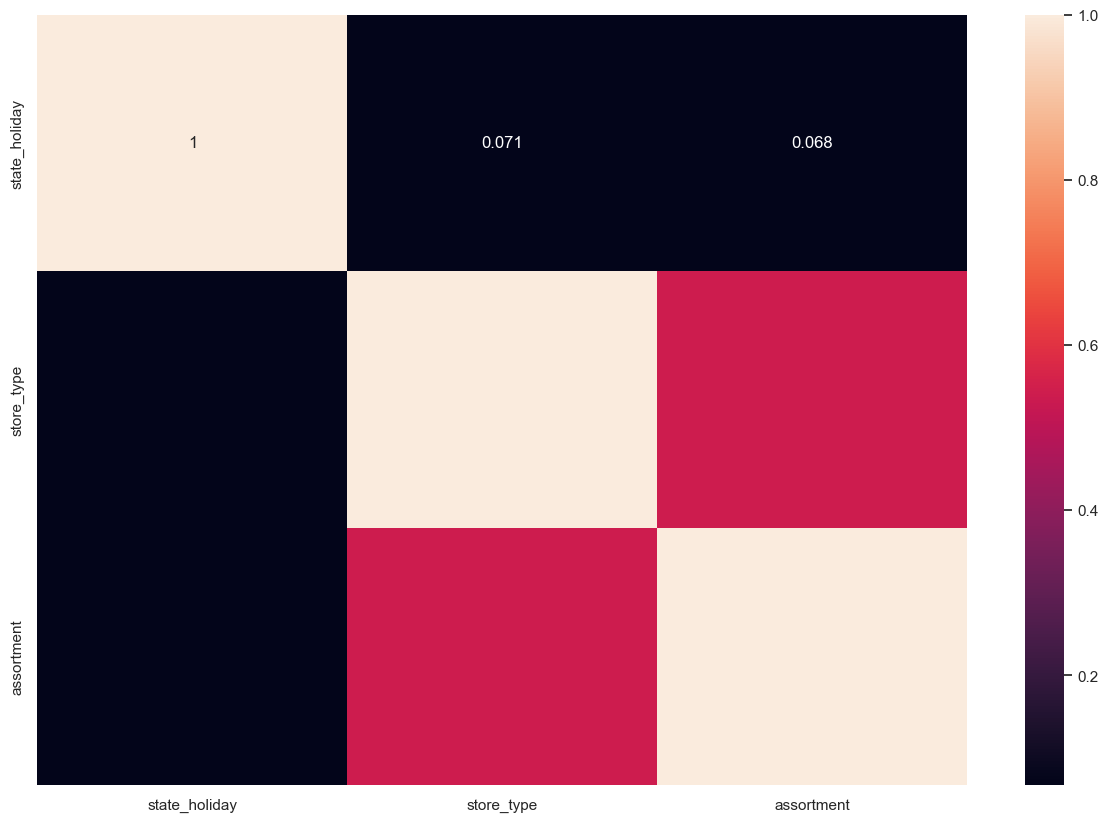

In [65]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

print(pd.DataFrame(d))
sns.heatmap( d, annot=True )

In [66]:
# Another way of calculating cramer_v

# # Obtenha uma lista de todas as colunas categóricas
# cat_cols = df4.select_dtypes(include='object').columns

# # Crie um novo DataFrame para armazenar os resultados
# cramer_v_df = pd.DataFrame(index=cat_cols, columns=cat_cols)

# # Calcule o cramer_v para cada par de colunas
# for col1 in cat_cols:
#     for col2 in cat_cols:
#         cramer_v_df.loc[col1, col2] = cramer_v(df4[col1], df4[col2])

# # Converta os resultados para float
# cramer_v_df = cramer_v_df.astype(float)

# # Crie um heatmap dos resultados
# sns.heatmap(cramer_v_df, annot=True)

## 5.0. PASSO 05 - DATA PREPARATION

In [67]:
df5 = df4.copy()

### 5.1. Normalizacao

##### Sem features com distribuição normal para normalizar. Farei apenas o rescaling.

### 5.2. Rescaling

In [68]:
a = df5.select_dtypes( include= ['int64', 'int32', 'float64'] )
print(a.columns)

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'month', 'day',
       'competition_time_month', 'promo_time_week'],
      dtype='object')


#### 5.2.1. Checking The Use of Robust or Min-Max Scaler

<Axes: >

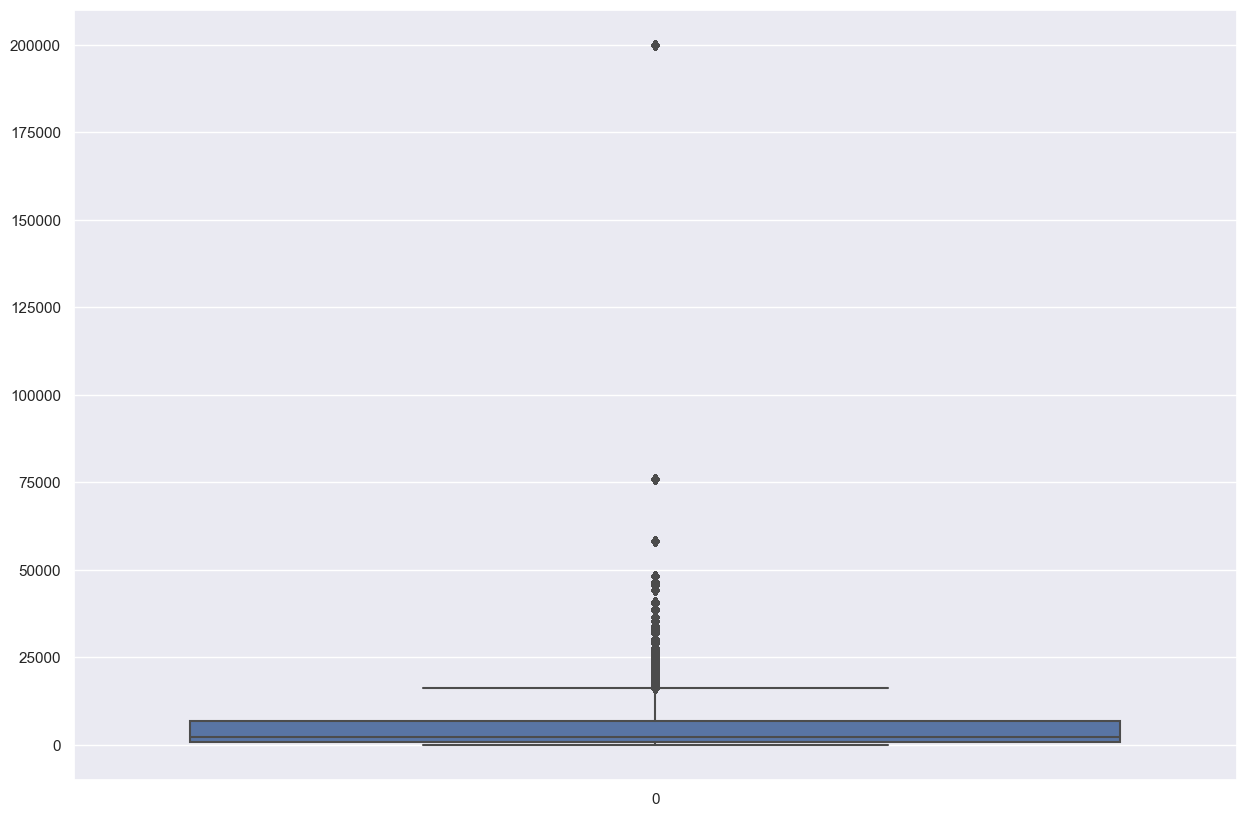

In [69]:
sns.boxplot(df5['competition_distance'])

<Axes: >

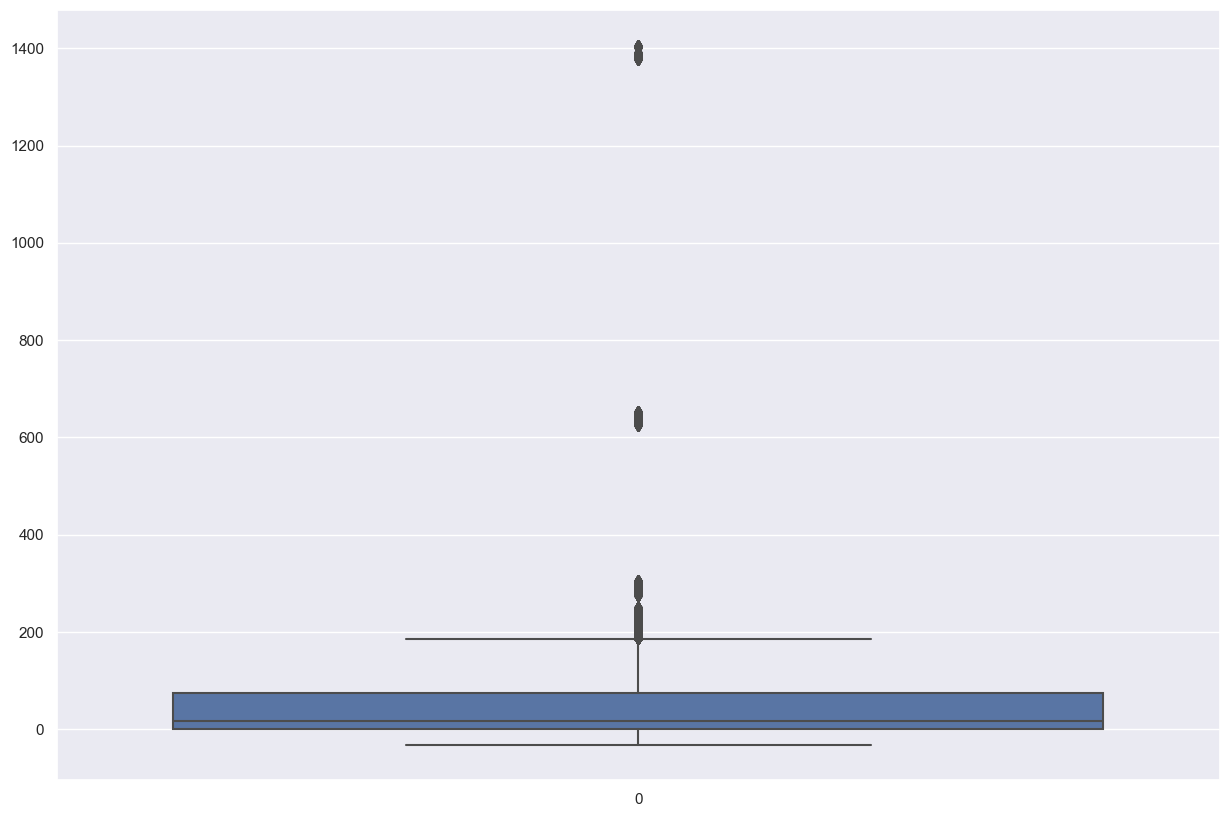

In [70]:
sns.boxplot(df5['competition_time_month'])

<Axes: >

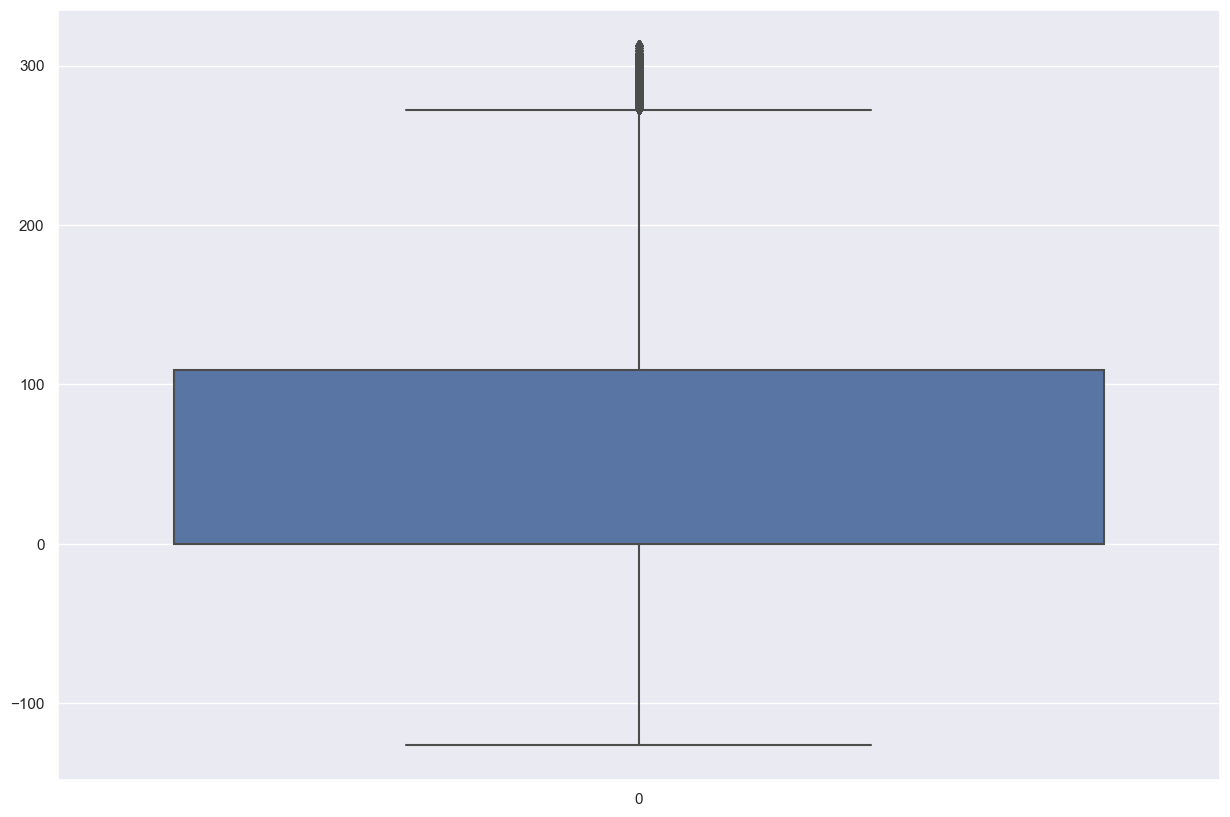

In [71]:
sns.boxplot(df5['promo_time_week'])

#### 5.2.2 Variables Chosen

In [72]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

In [73]:
rs = RobustScaler()
mms = MinMaxScaler()    

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
pickle.dump(rs, open('./webapp/parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
pickle.dump(rs, open('./webapp/parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump(rs, open('./webapp/parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump(rs, open('./webapp/parameter/year_scaler.pkl', 'wb'))

### 5.3. Transformacao

#### 5.3.1 Encoding

In [74]:
# Hot Encoding with state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [75]:
# Label Encoding with store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
# pickle
pickle.dump(le, open('./webapp/parameter/store_type_scaler.pkl', 'wb'))

In [76]:
# Ordinal Encoding with assortment
assort_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assort_dict)

#### 5.3.2 Response Variable Transformation

In [77]:
df5['sales'] = np.log1p(df5['sales'])

In [151]:
df5['sales'].head()

0    8.568646
1    8.710290
2    9.025816
3    9.546527
4    8.481151
Name: sales, dtype: float64

#### 5.3.3 Nature Transformation

In [78]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 )))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 )))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52 )))

## 6.0. PASSO 06 - FEATURE SELECTION

In [79]:
df6 = df5.copy()

### 6.1. Split Dataframe into Training and test Dataset

#### 6.1.1. Checking min and max dates

In [80]:
# checking the min date of dataset
df6.loc[ :, ['store', 'date']].groupby('store').min().sort_values(by='date', ascending=True).reset_index().head(1)

,store,date
0,562,2013-01-01


In [81]:
# checking the min date of dataset
df6.loc[:, ['store', 'date']].groupby('store').min().reset_index()['date'][0]

Timestamp('2013-01-02 00:00:00')

In [82]:
# checking the max date of dataset
df6.loc[ :, ['store', 'date']].groupby('store').max().sort_values(by='date', ascending=False).reset_index().head(1)

,store,date
0,1,2015-07-31


#### 6.1.2. Defining Train and Test Dataset

In [83]:
# Train dataset = min date until the day before last 6 weeks -> from 2013-01-01 to 2015-06-18
# Test dataset = last 6 sales weeks -> from 2015-06-19 to 2015-07-31

df6.loc[ :, ['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [84]:
# dropping cols not relevant for the model
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week', 'year_month_sales']
df6 = df6.drop(cols_drop, axis=1)

In [85]:
# training dataset
X_train = df6.loc[ df6['date'] < '2015-06-19', : ]
y_train = X_train['sales']

# test dataset
X_test = df6.loc[ df6['date'] >= '2015-06-19', : ]
y_test = X_test['sales']

print(f'Training Min Date: {X_train["date"].min()}')
print(f'Training Max Date: {X_train["date"].max()}')

print(f'Test Min Date: {X_test["date"].min()}')
print(f'Test Max Date: {X_test["date"].max()}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.2. Boruta as Feature Selector

In [86]:
# preparing training and test dataset for Boruta
X_train_n = X_train.drop(['sales', 'date'], axis=1).values
y_train_n = y_train.values.ravel() # transforming y_train into a 1D array

In [87]:
# define RandomForestRegressor (usamos -1 para usar todos os cores da máquina)
#rf = RandomForestRegressor(n_jobs=-1)

rf = pickle.load(open('./pickle/rf.pkl', 'rb'))

In [88]:
# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

boruta = pickle.load(open('./pickle/boruta.pkl', 'rb'))

#### 6.2.1 Best Feature from Boruta

In [89]:
# ranking best features with boruta.support_
cols_selected = boruta.support_.tolist() # create a boolean list

# picking columns Boruta selected from X_train dataset
X_train_fs = X_train.drop(['sales', 'date'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))


In [90]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [91]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

#### 6.3 Manual Feature Selection

In [92]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add to the model
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [93]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

In [94]:
print(np.isinf(x_training).sum())

store                           0
promo                           0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
competition_time_month          0
promo_time_week                 0
day_of_week_sin                 0
day_of_week_cos                 0
month_sin                       0
month_cos                       0
day_sin                         0
day_cos                         0
week_of_year_sin                0
week_of_year_cos                0
date                            0
sales                           0
dtype: int64


### 7.1. Average Model

In [95]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1.loc[ :, ['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


### 7.2. Linear Regression Model


In [96]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation


In [97]:
lr_result_cv = cross_validation_ml(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.3. Linear Regression Regularized Model - Lasso

In [98]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Linear Regression Regularized Model - Lasso - Cross Validation

In [99]:
lrr_result_cv = cross_validation_ml(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


### 7.4. Random Forest Regressor

In [100]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

In [101]:
# pickle.dump(rf, open('./pickle/rf_ml.pkl', 'wb'))

In [102]:
# rf = pickle.load(open('./pickle/rf_ml.pkl', 'rb'))

In [103]:
# prediction 
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest Regressor - Cross Validation

In [104]:
# rf_result_cv = cross_validation_ml(x_training, 5, 'Random Forest', rf, verbose=False)
# rf_result_cv

In [105]:
# pickle.dump(rf_result_cv, open('./pickle/rf_result_cv.pkl', 'wb'))

In [106]:
rf_result_cv = pickle.load(open('./pickle/rf_result_cv.pkl', 'rb'))

### 7.5. XGBoost Regressor

In [107]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1685.0258,0.250304,2463.213643


### 7.5.1. XGBoost Regressor - Cross Validation

In [108]:
xgb_result_cv = cross_validation_ml(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5



KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1859.87 +/- 289.14,0.25 +/- 0.01,2688.49 +/- 432.73


### 7.6. Compare Model´s Performance

#### 7.6.1 Single Performance

In [109]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1685.025800,0.250304,2463.213643
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso,1891.704881,0.289106,2744.451737


#### 7.6.2 Real Performance - Cross Validation

In [110]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,1859.87 +/- 289.14,0.25 +/- 0.01,2688.49 +/- 432.73


## 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

### 8.1. Random Search

In [111]:
param = {
            'n_estimators': [1500, 1700, 2500, 3000, 3500],
            'eta': [0.01, 0.03],
            'max_depth': [3,5,9],
            'subsample': [0.1,0.5,0.7],
            'colsample_bytree': [0.3, 0.7, 0.9],
            'min_child_weight': [3,8,15]
}

MAX_EVAL = 5

In [112]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     hp = {k: random.sample(v,1)[0] for k, v in param.items() }
#     print(hp)

#     # model
#     model_xgb = xgb.XGBRegressor(
#                                     objective='reg:squarederror',
#                                     n_estimators=hp['n_estimators'],
#                                     eta=hp['eta'],
#                                     max_depth=hp['max_depth'],
#                                     subsample=hp['subsample'],
#                                     colsample_bytree=hp['colsample_bytree'],
#                                     min_child_weight=hp['min_child_weight']
#                                     )
    
#     # performance 
#     result = cross_validation_ml(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])

In [113]:
#pickle.dump(final_result, open('./pickle/final_result.pkl', 'wb'))

In [114]:
final_result = pickle.load(open('./pickle/final_result.pkl', 'rb'))

In [115]:
final_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1411.64 +/- 140.34,0.2 +/- 0.01,2040.12 +/- 176.36
0,XGBoost Regressor,1088.98 +/- 123.93,0.15 +/- 0.01,1575.27 +/- 169.22
0,XGBoost Regressor,1606.02 +/- 159.15,0.22 +/- 0.01,2316.35 +/- 203.48
0,XGBoost Regressor,1715.38 +/- 178.95,0.24 +/- 0.01,2473.1 +/- 238.22
0,XGBoost Regressor,1687.9 +/- 175.05,0.24 +/- 0.01,2435.47 +/- 228.79


### 8.2. Final Model

In [116]:
param_tuned = {
    'n_estimators': 1500 ,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

In [117]:
# model
model_xbg_tuned = xgb.XGBRegressor(
                                    objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight']
                                    ).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xbg_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor Tuned', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor Tuned,921.539051,0.138662,1332.100017


In [118]:
# MPE
mpe = mean_percentage_error( np.expm1( y_test), np.expm1(yhat_xgb_tuned))
mpe
# underestimating the sales by 2.2%

-0.02266136436408018

## 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [119]:
df9 = X_test[cols_selected_boruta_full].copy()

# rescale
df9.loc[:, 'sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned)

### 9.1. Business Performance

In [120]:
# sum of predictions
df91 = df9.loc[:, ['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9.loc[ :, ['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename( columns= {0: 'MAE'})
df9_aux2 = df9.loc[ :, ['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_aboslute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns= {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92.loc[:, ['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [121]:
# most chalennging stores to the model (highest MAPE)
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,114310.593750,110814.086272,117807.101228,3496.507478,0.668503
434,435,168648.390625,167081.163931,170215.617319,1567.226694,0.541183
908,909,199558.156250,191132.621115,207983.691385,8425.535135,0.533302
472,473,180920.437500,179309.939348,182530.935652,1610.498152,0.527214
901,902,222432.593750,220418.415673,224446.771827,2014.178077,0.505989


<Axes: xlabel='store', ylabel='MAPE'>

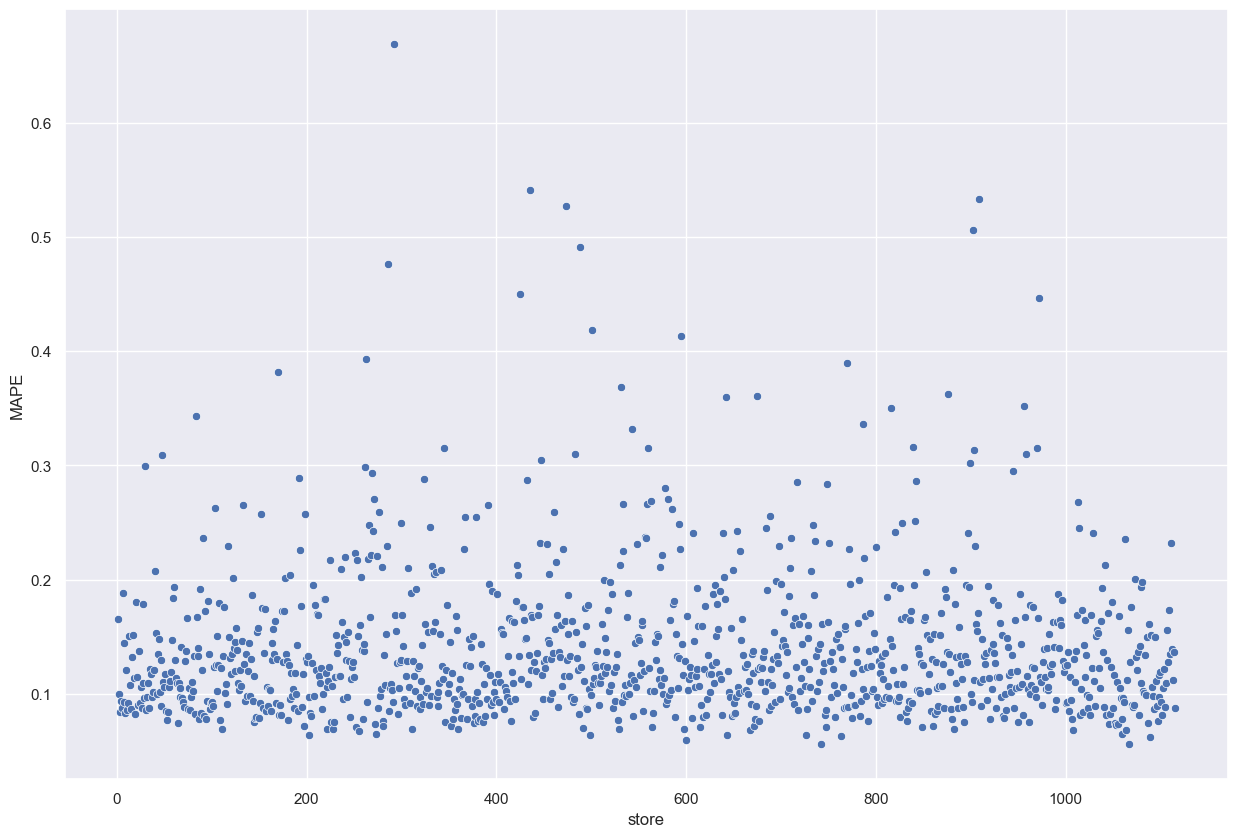

In [122]:
sns.scatterplot(x='store', y='MAPE', data=df92)

### 9.2. Total Performance

In [123]:
df93 = df92.loc[ :, ['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'})

df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$ 283,399,840.00"
1,worst_scenario,"R$ 282,370,061.34"
2,best_scenario,"R$ 284,429,652.43"


### 9.3. Machine Learning Performance

In [124]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Felipe\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

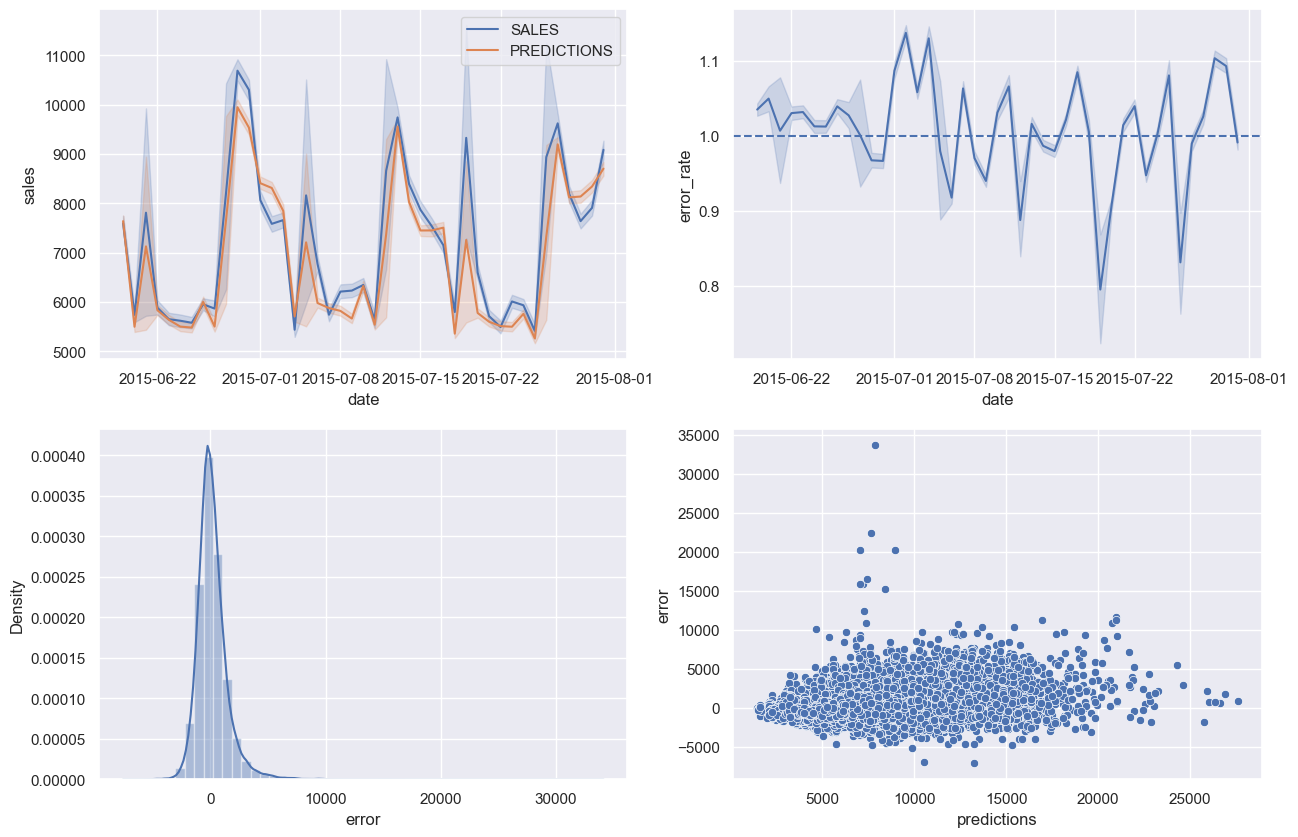

In [152]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--');

plt.subplot(2,2,3)
sns.distplot( df9['error']);

plt.subplot(2,2,4)
# residual graph = predictions vs error
sns.scatterplot(x=df9['predictions'], y=df9['error']);

## 10. PASSO 10 - DEPLOY DO MODELO EM PRODUCAO

In [126]:
# save Trained Model
pickle.dump(model_xbg_tuned, open('./webapp/model/model_rossmann.pkl', 'wb'))

### 10.1. Rossmann Class

In [127]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math 
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path = ''
        # pickle
        self.competition_distance_scaler    = pickle.load(open( self.home_path + './webapp/parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler  = pickle.load(open( self.home_path + './webapp/parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler         = pickle.load(open( self.home_path + './webapp/parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                    = pickle.load(open( self.home_path + './webapp/parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler              = pickle.load(open( self.home_path + './webapp/parameter/store_type_scaler.pkl', 'rb'))

    def data_cleaning( self, df1):
        # rename columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        #transformando nome de colunas em snakecase
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new

        # Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        # Fillout NA
        # replacing na from competition_distance with value 200000
        df1['competition_distance'] = df1['competition_distance'].fillna(200000)
        # another way of doing it
        #df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month receive the 'date' month -> the competitor time open will be zero
        df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month).astype(int)

        # competition_open_since_month receive the 'date' year -> the competitor time open will be zero
        df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year).astype(int)

        # promo2_since_week receive the 'date' week -> the diff will be zero (store didnt take part in promo2)
        df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week).astype(int)

        # promo2_since_year receive the 'date' year -> the diff will be zero (store didnt take part in promo2)
        df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['date'].dt.year).astype(int)

        # promo_interval with 0 in place of NA
        df1['promo_interval'].fillna(0, inplace=True)

        # month dictionary to create new column month_map -> split promo_interval and check if month_map is in
        month_map = { 1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        # creating column is_promo -> which months took part in promo2
        df1['is_promo'] = df1.loc[:, ['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        # Change Data Types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
    
    def feature_engineering( self, df2):

        # Derivando as variáveis necessárias
        # year
        df2['year'] = df2['date'].dt.year
        # month 
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since -> time since the competitor opened
        df2['competition_since'] = df2['competition_open_since_year'].astype(str) + '-' + df2['competition_open_since_month'].astype(str).str.zfill(2)
        df2['competition_since'] = pd.to_datetime(df2['competition_since'], format='%Y-%m')
        # df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1 )
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        # promo since -> how long the store is participating in promo2
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str).str.zfill(2)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')) - datetime.timedelta( days = 7)
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /7).apply( lambda x: x.days).astype(int)

        # assortment
        assort_dict = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
        df2['assortment'] = df2['assortment'].map(assort_dict)
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # Filtragem de Variáveis
        # just stores that are open
        df2 = df2[ (df2['open'] != 0) ]

        # droping columns not necessary anymore
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2
    
    def data_preparation( self, df5):
        # rescaling
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values)

        # Encoding
        # Hot Encoding with state_holiday
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type -> label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment  -> Ordinal Encoding
        assort_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assort_dict)

        # Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2 * np.pi/7)))
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2 * np.pi/12)))
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2 * np.pi/30)))
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2 * np.pi/52)))

        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                         'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin',
                         'day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']                    

        return df5[cols_selected]
    
    def get_prediction( self, model, original_data, test_data):
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json( orient='records', date_format='iso')


### 10.2. API Handler

In [128]:
import pandas as pd
from flask import Flask, request, Response
from api.rossmann.Rossmann import Rossmann
import pickle
import os

# loading model
model = pickle.load(open('./webapp/model/model_rossmann.pkl', 'rb'))

app = Flask(__name__)

# defining endpoint com os métodos que recebe
@app.route('/rossmann/predict', methods=['POST'])

# after POST, endpoint will run rossmann_predict
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # is there data?
        if isinstance(test_json, dict): # Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        # data preparation
        df3 = pipeline.data_preparation(df2)
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    port = int(os.environ.get('PORT', 5000))
    app.run(host='0.0.0.0', port=port,debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.0.0.238:5000
Press CTRL+C to quit


### 10.3. API Tester

In [129]:
import requests

In [130]:
# loading test dataset
df10 = pd.read_csv('./data/test.csv')

In [131]:
# merging test dataset with store dataset
df_test = pd.merge(df10, df_stores_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test.loc[ df_test['Store'].isin( [24,22,12,10,110,13]), :]

# remove closed days
df_test = df_test.loc[ df_test['Open'] != 0, :]
df_test = df_test.loc[ ~df_test['Open'].isnull(), : ]
df_test = df_test.drop('Id', axis=1)

In [132]:
# convert DataFrame to json
data = json.dumps( df_test.to_dict(orient='records'))

In [ ]:
# API Call
url = 'https://rossmann-sales-o2or.onrender.com/rossmann/predict'
# url = 'http://127.0.0.1:5000/rossmann/predict'
header = { 'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 200


In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1.loc[ :, ['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print(f'Store Number {d2.loc[i, "store"]} will  sell {d2.loc[i, "prediction"]:,.2f} in the next 6 weeks')

Store Number 10 will  sell 208,330.22 in the next 6 weeks
Store Number 12 will  sell 309,989.33 in the next 6 weeks
Store Number 13 will  sell 259,726.19 in the next 6 weeks
Store Number 22 will  sell 174,418.25 in the next 6 weeks
Store Number 24 will  sell 339,075.89 in the next 6 weeks
Store Number 110 will  sell 167,992.17 in the next 6 weeks
